# Load Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
from sklearn.impute import SimpleImputer
import scipy
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import ppscore as pps

# Load Data
## Load Relevant 2003 and 2004 LEAPS Datasets

In [2]:
# 2003 leaps data
child_03 = pd.read_stata('/Users/Documents/Data/LEAPS/LEAPS data/2003/public_child1.dta',
            columns = ['childcode', 'ch1_s1q3'])
child_roster_03 = pd.read_stata('/Users/Documents/Data/LEAPS/LEAPS/LEAPS data/2003/public_childroster1.dta',
            columns = ['childcode', 'cr1_s1q5', 'cr1_s2q6'])
hhs_household_03 = pd.read_stata('/Users/Documents/Data/LEAPS/LEAPS data/2003/public_hhsurvey1_household.dta',
            columns = ['hhid', 'mauzaid', 'hf1_s13q1_have', 'hf1_s13q3_have', 'hm1_s11q1'])
master_children_03 = pd.read_stata('/Users/Documents/Data/LEAPS/LEAPS data/2003/public_master_children1.dta',
            columns = ['childcode', 'hhid', 'child_teachercode1', 'child_schoolid1',
                      'child_english_scale1', 'child_urdu_scale1', 'child_math_scale1', 'child_female'])
teacher_roster_03 = pd.read_stata('/Users/Documents/Data/LEAPS/LEAPS data/2003/public_teacherroster1.dta',
            columns = ['child_teachercode1', 'tr1_s1q2', 'tr1_s1q4', 'tr1_s1q7', 'tr1_s1q8', 'tr1_s1q9',
                       'tr1_s1q10', 'tr1_s1q11'])
                
# 2004 leaps data
master_children_04 = pd.read_stata('.../LEAPS data/2004/public_master_children2.dta',
            columns = ['childcode', 'hhid', 'child_teachercode2', 'child_female','child_english_scale2', 'child_math_scale2', 'child_urdu_scale2', 'child_class2'])
child_04 = pd.read_stata('.../LEAPS data/2004/public_child2.dta',
            columns = ['childcode', 'ch2_s1q3', 'ch2_s2q2', 'ch2_s2q3']) # ch2_s0q1_code from correlation assessment
child_roster_04 = pd.read_stata('.../LEAPS data/2004/public_childroster2.dta',
            columns = ['childcode', 'cr2_s2q6', 'cr2_s2q7'])
hhs_household_04 = pd.read_stata('.../LEAPS data/2004/public_hhsurvey2_household.dta', convert_categoricals=False,
            columns = ['hhid', 'h2_s0q1_code', 'h2_s13q8', 'h2_s0q4_code'])
hhs_member_04 = pd.read_stata('.../LEAPS data/2004/public_hhsurvey2_member.dta',
            columns = ['hhid', 'h2_s4q3_type', 'h2_s4q4',
                        'h2_s10q4_sub2', 'h2_s5q2e3'])
hhs_school_04 = pd.read_stata('.../LEAPS data/2004/public_hhsurvey2_school.dta',
            columns = ['hhid'])
teacher_04 = pd.read_stata('.../LEAPS/LEAPS data/2004/public_teacher2.dta',
            columns = ['teachercode2t','tq2_s3q1','tq2_s8q1','tq2_s8q3', 'tq2_s8q5'])
teacher_roster_04 = pd.read_stata('.../LEAPS data/2004/public_teacherroster2.dta',
            columns = ['teachercode2tr', 'tr2_q4', 'tr2_q8', 'tr2_q7', 'tr2_q11'])

## Make DataFrame for 2003: df2003

In [3]:
grades_03 = master_children_03.rename(columns = {'child_english_scale1': 'english', 'child_urdu_scale1': 
                'urdu', 'child_math_scale1': 'math', 'child_female': 'student_sex'})

merge1_03 = pd.merge(grades_03, child_roster_03,
                on = 'childcode', how = 'left',suffixes=('left','right'))
merge1_03 = merge1_03.rename(columns = {'childcode': 'childcode', 'cr1_s1q5': 'grade',
                'cr1_s2q6': 'teacher_rates_child_how_good_in_studies'})

merge2_03 = pd.merge(merge1_03, child_03,
                on = 'childcode', how = 'left', suffixes = ('left','right'))
merge2_03 = merge2_03.rename(columns = {'childcode': 'childcode',
                'ch1_s1q3': 'child_studied_at_diff_school'})

merge3_03 = pd.merge(merge2_03, teacher_roster_03,
                on = 'child_teachercode1', how = 'left', suffixes = ('left','right'))
merge3_03 = merge3_03.rename(columns = {'child_teachercode1': 'child_teachercode', 'tr1_s1q2': 'teacher_sex',
                'tr1_s1q4': 'teacher_years_teaching',
                'tr1_s1q7': 'teacher_qualifications', 'tr1_s1q8': 'teacher_training', 'tr1_s1q9': 'salary_monthly_Rs',
                'tr1_s1q10': 'teacher_from_mauza',
                'tr1_s1q11': 'teacher_days_absent_last_mo'})

df2003 = pd.merge(merge3_03, hhs_household_03,
                on = 'hhid', how = 'left', suffixes = ('left','right'))
df2003 = df2003.rename(columns = {                                
                'hhid': 'hhid', 'hf1_s13q1_have': 'print_have',
                'hf1_s13q3_have': 'i_vis_have', # df2004.tv corresponds with this.
                'hm1_s10q1': 'death_5_years',
                'hm1_s11q1': 'own_agri_land_last_2_seasons'})

# add grade_median and grade_mean to df2003
df2003.insert(0, 'grade_median', df2003.iloc[:,3:6].median(numeric_only = True, axis = 1))

## Make DataFrame for 2004: df2004

In [4]:
grades_04 = master_children_04
grades_04 = grades_04.rename(columns = {'childcode': 'childcode', 'hhid': 'hhid',
                'child_teachercode2': 'child_teachercode',
                'child_female': 'student_sex', 'child_english_scale2': 'english',
                'child_math_scale2': 'math', 'child_urdu_scale2': 'urdu', 'child_class2': 'grade'})

# 04 hh_surveys
merge1_04 = pd.merge(grades_04, hhs_household_04, on = 'hhid', how = 'left')

merge2_04 = pd.merge(merge1_04, hhs_member_04, on = 'hhid', how = 'left')
merge2_04 = merge2_04.rename(columns = {'h2_s4q3_type': 'school_type',
                'h2_s4q4': 'studied_at_same_school_as_last_year'})

merge3_04 = pd.merge(merge2_04, hhs_school_04, on='hhid', how='left')

# 04 teachers
teacher_04 = teacher_04.rename(columns = {'teachercode2t': 'teachercode','tq2_s3q1': 'teacher_sex',
                'tq2_s8q1': 'teacher_survey_absent_emergency', 'tq2_s8q3':'teacher_survey_absent_office_work',
                'tq2_s8q5': 'teacher_survey_absent_other_work'})
merge3_04.insert(2, 'teachercode', teacher_04['teachercode']) # merge3_04 needs column 'teachercode' to merge on.
merge4_04 = pd.merge(merge3_04, teacher_04,
                on = 'teachercode', how = 'left') # this is a new kind of data, corresponding to teacher_days_absent_last_mo

teacher_roster_04 = teacher_roster_04.rename(columns = {'teachercode2tr': 'teachercode',
                'tr2_q4': 'teacher_years_teaching',
                'tr2_q7': 'teacher_qualifications', 'tr2_q8': 'teacher_training',
                'tr2_q11': 'teacher_from_mauza'})
merge5_04 = pd.merge(merge4_04, teacher_roster_04, on = 'teachercode', how = 'left')

# 04 students
merge6_04 = pd.merge(merge5_04, child_04, on = 'childcode', how = 'left')
merge6_04 = merge6_04.rename(columns = {'ch2_s1q3': 'child_studied_at_diff_school',
                'ch2_s2q2': 'radio', 'ch2_s2q3': 'television'}) # radio and TV replace audio and vis_i of 2003
                      
merge7_04 = pd.merge(merge6_04, child_roster_04, on = 'childcode', how = 'left')
df2004 = merge7_04.rename(columns = {'cr2_s2q6': 'child_days_absent_last_mo',
                # The online data does not specify 'month', but must be monthly because the range is 0-31.
                'cr2_s2q7': 'teacher_rates_child_how_good_in_studies', 'h2_s0q1_code': 'supervisor_code',
                'h2_s13q8': 'hh_child_in_govt_primary_school', 'h2_s0q4_code': 'tehsil_census_code',
                'h2_s10q4_sub2': 'child_helped', 'h2_s5q2e3': 'type_of_housework_timeslot_5'})

# add grade_median and grade_mean to df2004
df2004.insert(0, 'grade_median', df2004.iloc[:, 4:7].median(numeric_only = True, axis = 1))

# Clean Data

## Missing Data and Solutions

In [5]:
# The below percentage shows there is much missing data for 2003 outside
# of the targeted questionnaires. Missing target variables have already been dealt with in the df grades.
total = df2003.isnull().sum().sort_values(ascending=False)
percent = (df2003.isnull().sum()/df2003.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
print(missing_data[missing_data['Total'] > 0].round({'Missing Percent': 2}))

                                         Total  Missing Percent
own_agri_land_last_2_seasons             12741            92.76
i_vis_have                               12738            92.74
print_have                               12738            92.74
mauzaid                                  12738            92.74
hhid                                     12738            92.74
child_studied_at_diff_school              7363            53.61
teacher_rates_child_how_good_in_studies   7347            53.49
math                                      1625            11.83
urdu                                      1625            11.83
english                                   1625            11.83
teacher_training                           280             2.04
teacher_days_absent_last_mo                117             0.85
teacher_from_mauza                          56             0.41
salary_monthly_Rs                           19             0.14
teacher_years_teaching                  

In [6]:
# The below percentage shows there is much missing data for 2004 outside
# of the targeted questionnaires. All missing target variables have already been dealt with in the df grades.
total = df2004.isnull().sum().sort_values(ascending=False)
percent = (df2004.isnull().sum() / df2004.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
print(missing_data[missing_data['Total'] > 0].round({'Missing Percent': 2}))

                                          Total  Missing Percent
teacher_years_teaching                   108363            99.27
teacher_from_mauza                       108362            99.27
teacher_qualifications                   108361            99.27
teacher_training                         108361            99.27
teacher_survey_absent_other_work         108361            99.27
teacher_survey_absent_office_work        108361            99.27
teacher_survey_absent_emergency          108361            99.27
teacher_sex                              108361            99.27
teachercode                              108361            99.27
type_of_housework_timeslot_5             107934            98.88
child_helped                             107417            98.41
studied_at_same_school_as_last_year       81069            74.27
school_type                               81069            74.27
television                                64725            59.29
radio                    

## Analysis of and Solutions for df2003 and df2004
### df2003 Analysis
The English, Urdu, and Math columns have several NaNs, and the median of the three are the target variable. They must all be dropped.<br>
Household (12,738) and teacher (~7,350) questionnaires can be left as NaN, as that's how the data gatherers intended the missing amount to look (unless I want to fill the missing events for those who filled out the questionnaires).<br><br>

### df2004 Analysis
As with df2003, The English, Urdu, and Math columns have several NaNs, and the median of the three are the target variable. They must all be dropped.<br>
The Household (~8,100) and teacher (10,8361) questionnaires can be left as NaN, as that's how the data gatherers intended the missing amount to look (unless I want to fill the missing events for those who filled out the questionnaires).<br><br>

### Solutions
(The true target variable is the median of english, urdu, and math, and the three grades it is based on I here call the target variables in order to avoid encumbersome language.)<br>
I will drop all the rows with NaN instances in the grade_median columns of each DataFrame because they constitute the target variable for predictive modeling.
<br><br>
I will fill the missing data that is less than 3% with the most common value, except for the "sex" column in df2004, which I will fill with the less common value "Male" (viz. 1).
<br><br>
(I have already dropped the missing data for my target variables in the grades DataFrame.)

# QUESTIONS

What do I do with majorly missing data? It's not a problem conceptually but is when I think of how to put it in code.<br>
Should I convert grade to integers? (3rd or 4th grade)

### Drop all NaN values from the target variable per year

In [7]:
df2003 = df2003[df2003['grade_median'].notna()]
df2003 = df2003[df2003['english'].notna()]
df2003 = df2003[df2003['urdu'].notna()]
df2003 = df2003[df2003['math'].notna()]

df2004 = df2004[df2004['grade_median'].notna()]
df2004 = df2004[df2004['english'].notna()]
df2004 = df2004[df2004['urdu'].notna()]
df2004 = df2004[df2004['math'].notna()]

### df2003: Fill in the missing values of the missing data that is less than 3%. I use sklearn.impute.SimpleImputer¶

In [8]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['teacher_training']])
df2003.teacher_training = imr.transform(df2003[['teacher_training']]).ravel()

In [9]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['teacher_days_absent_last_mo']])
df2003.teacher_days_absent_last_mo = imr.transform(df2003[['teacher_days_absent_last_mo']]).ravel()

In [10]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['teacher_days_absent_last_mo']])
df2003.teacher_days_absent_last_mo = imr.transform(df2003[['teacher_days_absent_last_mo']]).ravel()
# I change the floats to integers because no one missed a fraction of a day in this survey,
# indicating such was not an option for participants.
df2003.teacher_days_absent_last_mo = df2003.teacher_days_absent_last_mo.astype(int)

In [11]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['teacher_from_mauza']])
df2003.teacher_from_mauza = imr.transform(df2003[['teacher_from_mauza']]).ravel()

In [12]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['teacher_years_teaching']])
df2003.teacher_years_teaching = imr.transform(df2003[['teacher_years_teaching']]).ravel()

In [13]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2003[['salary_monthly_Rs']])
df2003.salary_monthly_Rs = imr.transform(df2003[['salary_monthly_Rs']]).ravel()

#### Minimize dtype

In [14]:
# Convert "childcode" to integer.
df2003.childcode = df2003.childcode.astype('int32')
df2004.childcode = df2004.childcode.astype('int32')

### df2004: Fill in the missing values of the missing data that is less than 3%.

In [15]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2004[['child_teachercode']])
df2004.child_teachercode = imr.transform(df2004[['child_teachercode']]).ravel()

In [16]:
imr = SimpleImputer(strategy='most_frequent')
imr = imr.fit(df2004[['grade']])
df2004.grade = imr.transform(df2004[['grade']]).ravel()

In [17]:
df2004.student_sex = df2004.student_sex.replace(to_replace=0.0, value='Male')
df2004.student_sex = df2004.student_sex.replace(to_replace=1.0, value='Female')
df2004.student_sex = df2004.student_sex.astype('category')

#### If I had more computing power, I would fill the missing ~3% of data using MICE (see code below) instead of the average in each category.<br>
cf. https://towardsdatascience.com/stop-using-mean-to-fill-missing-data-678c0d396e22
<br><br>

from impyute.imputation.cs import mice <br>

X = grades.drop('childcode', axis=1).values <br>

imputed = mice(X) <br>
mice_ages = imputed[:, 2]

grades.describe()

# EDA

## 2003

In [18]:
df2003.head(3)

grade_median  childcode  hhid  child_teachercode  child_schoolid1  english  \
0         614.0     101001   NaN              10104                1    705.0   
1         624.0     101002   NaN              10104                1    713.0   
2         656.0     101003   NaN              10104                1    704.0   

    urdu   math student_sex  grade  ...  teacher_years_teaching  \
0  614.0  606.0        Male      3  ...               > 3 Years   
1  624.0  595.0        Male      3  ...               > 3 Years   
2  656.0  624.0      Female      3  ...               > 3 Years   

  teacher_qualifications teacher_training salary_monthly_Rs  \
0              F.A./F.SC               CT            1200.0   
1              F.A./F.SC               CT            1200.0   
2              F.A./F.SC               CT            1200.0   

  teacher_from_mauza teacher_days_absent_last_mo  mauzaid print_have  \
0                 No                           0      NaN        NaN   
1                 No                           0      NaN        NaN   
2                 No                           0      NaN        NaN   

   i_vis_have  own_agri_land_last_2_seasons  
0         NaN                           NaN  
1         NaN                           NaN  
2         NaN                           NaN  

[3 rows x 23 columns]

In [19]:
df2003.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12110 entries, 0 to 13734
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   grade_median                             12110 non-null  float64 
 1   childcode                                12110 non-null  int32   
 2   hhid                                     917 non-null    float64 
 3   child_teachercode                        12110 non-null  int32   
 4   child_schoolid1                          12110 non-null  int8    
 5   english                                  12110 non-null  float64 
 6   urdu                                     12110 non-null  float64 
 7   math                                     12110 non-null  float64 
 8   student_sex                              12110 non-null  category
 9   grade                                    12110 non-null  int8    
 10  teacher_rates_child_how_good_in_st

12110

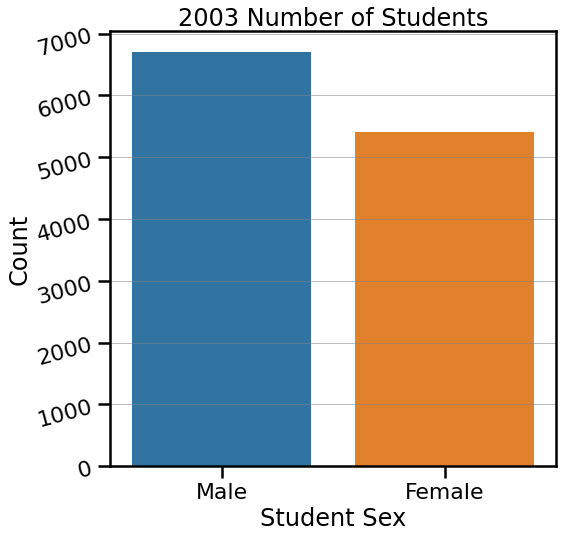

In [20]:
_ = plt.figure(figsize=(8, 8))
_ = sns.countplot(x='student_sex', data=df2003, order=['Male', 'Female'])
_ = plt.title('2003 Number of Students')
_ = plt.xlabel('Student Sex')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.grade_median.value_counts().sum()

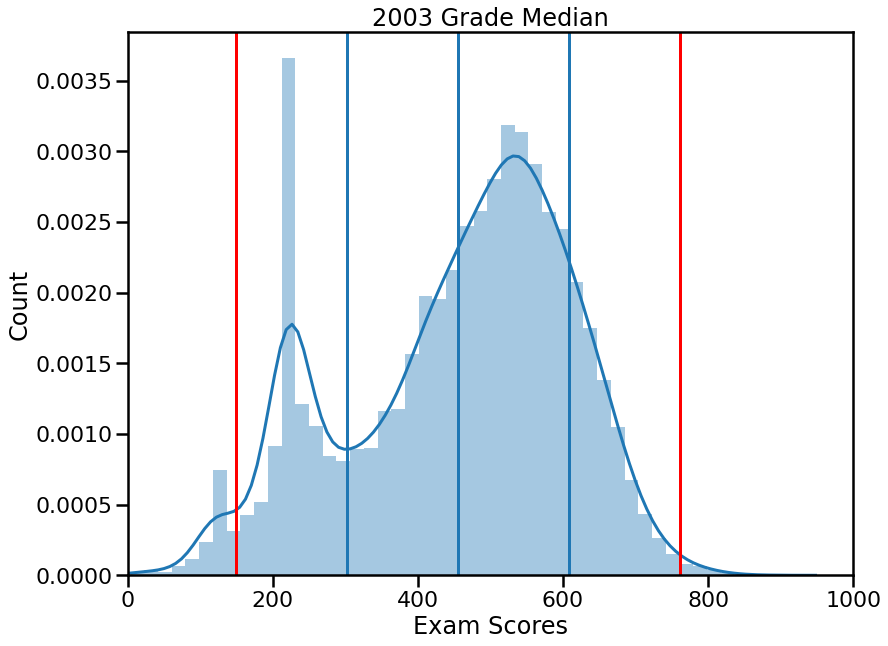

In [21]:
_ = plt.figure(figsize=(13, 10))
_ = sns.distplot(df2003.grade_median)
_ = plt.axvline(np.mean(df2003.grade_median) + np.std(df2003.grade_median))
_ = plt.axvline(np.mean(df2003.grade_median) + 2 * np.std(df2003.grade_median), c='r')
_ = plt.axvline(np.mean(df2003.grade_median) - np.std(df2003.grade_median))
_ = plt.axvline(np.mean(df2003.grade_median) - 2 * np.std(df2003.grade_median), c='r')
_ = plt.axvline(np.mean(df2003.grade_median))
_ = plt.xlim(0, 1000)
_ = plt.title('2003 Grade Median')
_ = plt.xlabel('Exam Scores')
_ = plt.ylabel('Count')

### I address this set's distributional irregularity in the "Outlines" section below. Many students scored just above 200 because the test is completed after they miss one question.

5.0     892
8.0     868
7.0     829
6.0     796
9.0     648
4.0     587
10.0    559
3.0     459
2.0     383
1.0     324
Name: teacher_rates_child_how_good_in_studies, dtype: int64

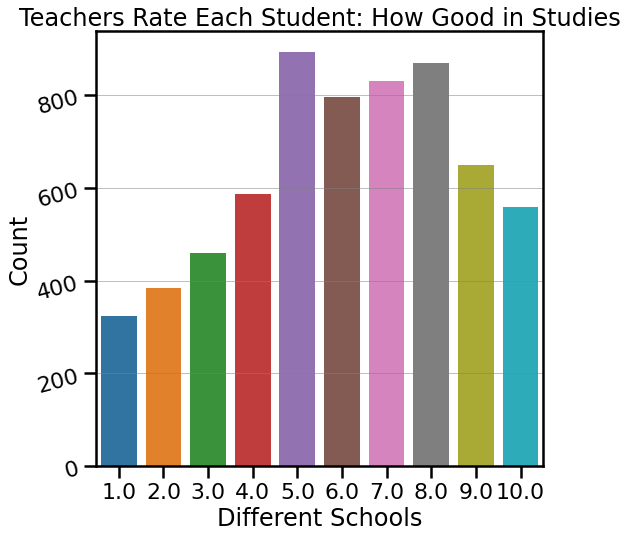

In [22]:
_ = plt.figure(figsize=(8, 8))
_ = sns.countplot(x='teacher_rates_child_how_good_in_studies', data=df2003)
_ = plt.title('Teachers Rate Each Student: How Good in Studies')
_ = plt.xlabel('Different Schools')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.teacher_rates_child_how_good_in_studies.value_counts()

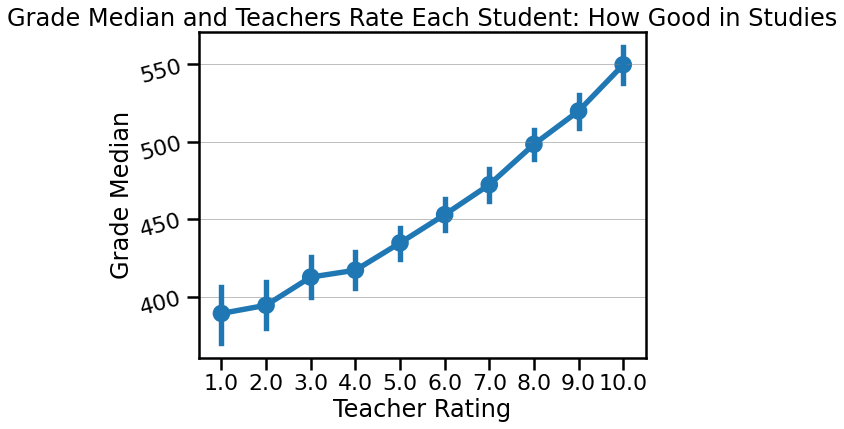

In [23]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_rates_child_how_good_in_studies', y='grade_median', data=df2003)
_ = plt.title('Grade Median and Teachers Rate Each Student: How Good in Studies')
_ = plt.xlabel('Teacher Rating')
_ = plt.ylabel('Grade Median')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### One might be reminded of the vast psychological research showing that teacher expectations and beliefs about children often influence their grades, though that is only one factor. E.g., https://www.npr.org/sections/health-shots/2012/09/18/161159263/teachers-expectations-can-influence-how-students-perform

12110

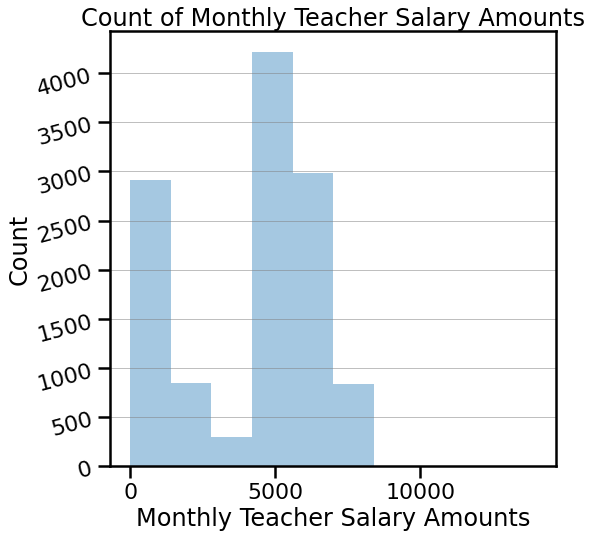

In [24]:
_ = plt.figure(figsize=(8, 8))
_ = sns.distplot(df2003['salary_monthly_Rs'], bins=10, kde=False)
_ = plt.title('Count of Monthly Teacher Salary Amounts')
_ = plt.xlabel('Monthly Teacher Salary Amounts')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.salary_monthly_Rs.count()

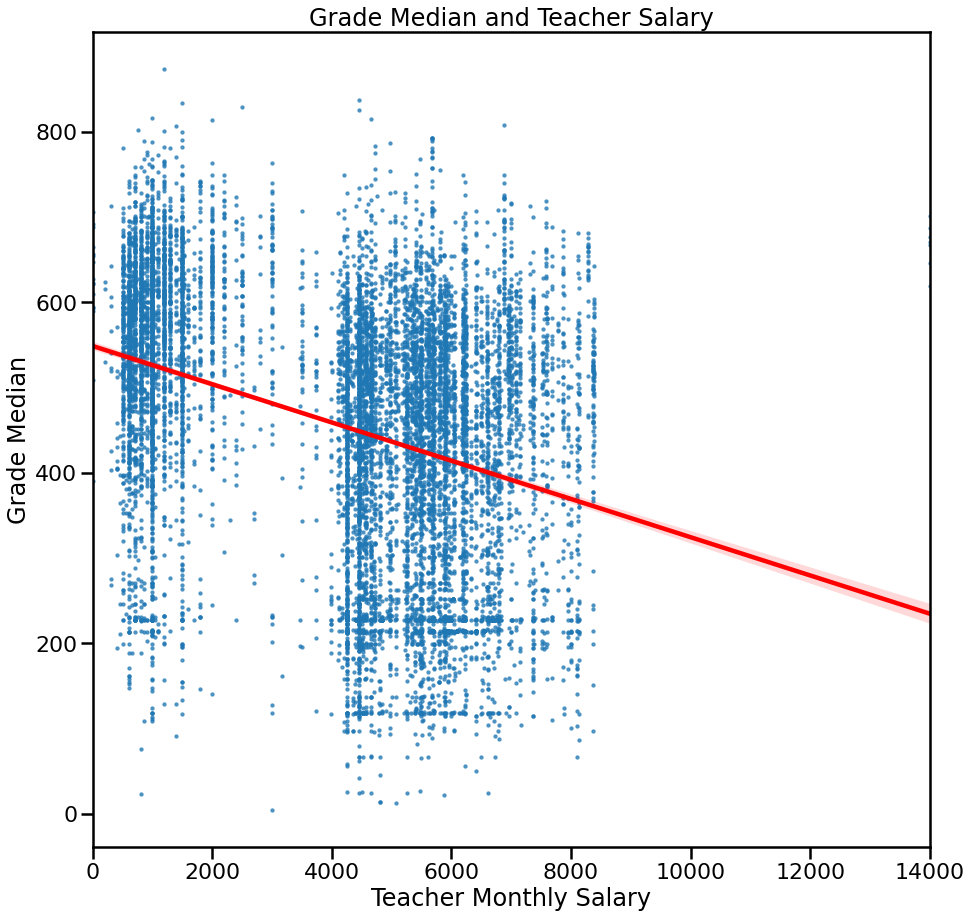

In [25]:
_ = plt.figure(figsize=(15, 15))
_ = sns.regplot(x='salary_monthly_Rs', y='grade_median', data=df2003,
                scatter_kws={'s':17, 'linewidth':.1},line_kws={'color':'red'})
_ = plt.title('Grade Median and Teacher Salary')
_ = plt.xlabel('Teacher Monthly Salary')
_ = plt.ylabel('Grade Median')

### If there is a meaningful correlation between teacher salaries and student success as measured by grade median, it is negative.

No     4717
Yes    1641
Name: child_studied_at_diff_school, dtype: int64

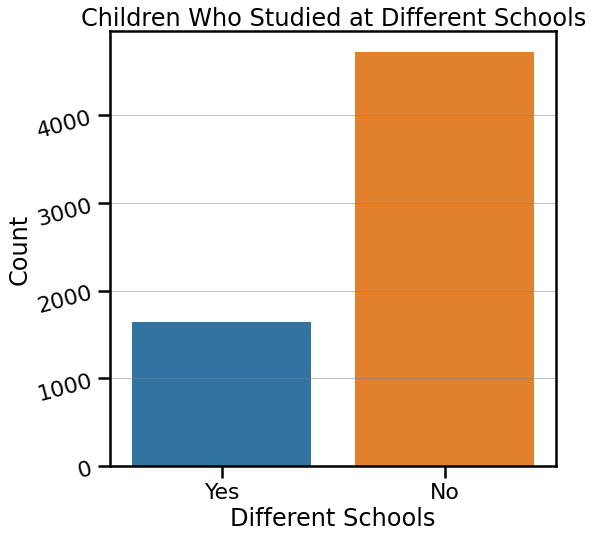

In [26]:
_ = plt.figure(figsize=(8, 8))
_ = sns.countplot(x='child_studied_at_diff_school', data=df2003)
_ = plt.title('Children Who Studied at Different Schools')
_ = plt.xlabel('Different Schools')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.child_studied_at_diff_school.value_counts()

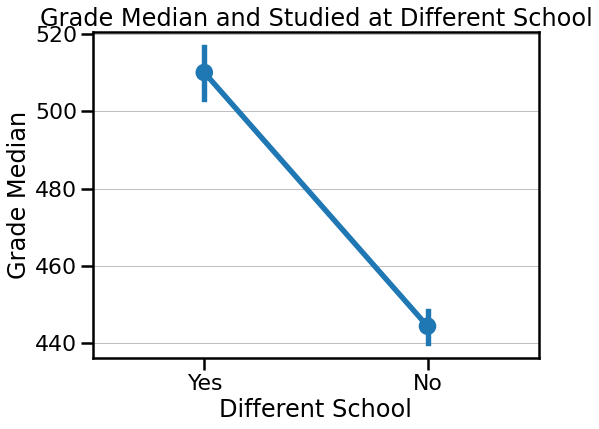

In [27]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='child_studied_at_diff_school', y='grade_median', data=df2003)
_ = plt.title('Grade Median and Studied at Different School')
_ = plt.xlabel('Different School')
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### Those who changed schools tended to perform better.

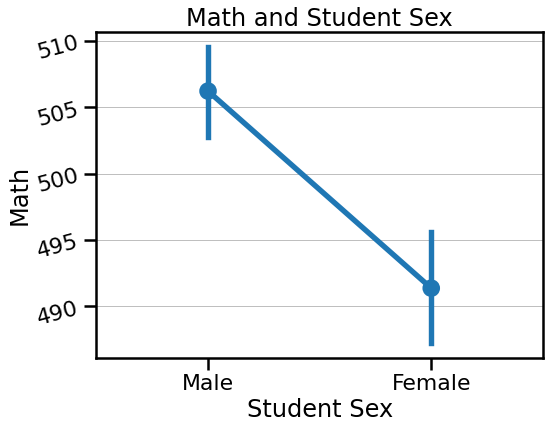

In [28]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='student_sex', y='math', data=df2003)
_ = plt.title('Math and Student Sex')
_ = plt.xlabel('Student Sex')
_ = plt.ylabel('Math')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

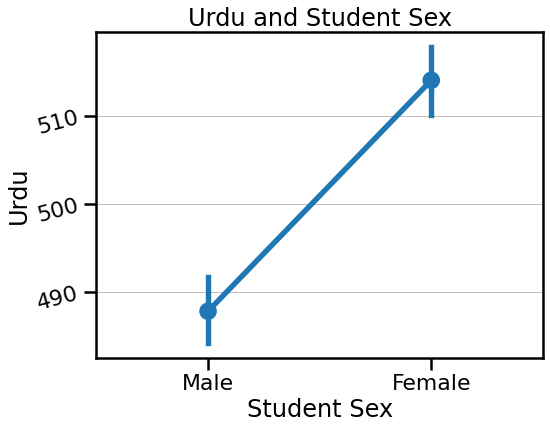

In [29]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='student_sex', y='urdu', data=df2003)
_ = plt.title('Urdu and Student Sex')
_ = plt.xlabel('Student Sex')
_ = plt.ylabel('Urdu')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

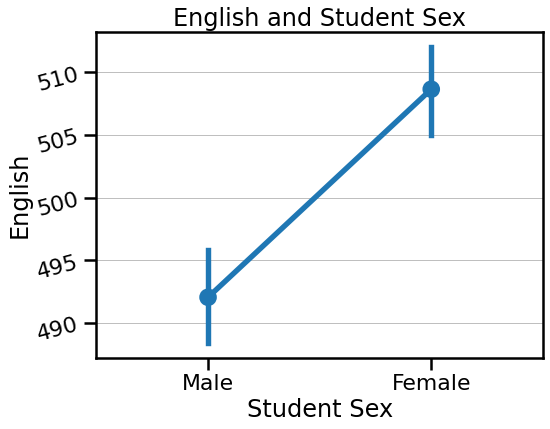

In [30]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='student_sex', y='english', data=df2003)
_ = plt.title('English and Student Sex')
_ = plt.xlabel('Student Sex')
_ = plt.ylabel('English')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### In the aggregate, males perform better in math, while females perform better in Urdu and English.

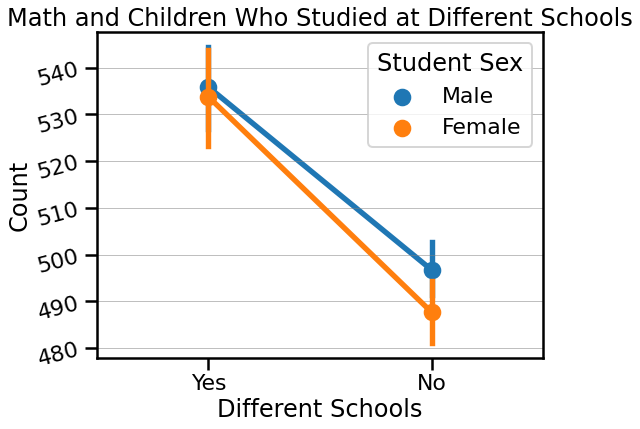

In [31]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='child_studied_at_diff_school', y='math', hue='student_sex', data=df2003)
_ = plt.title('Math and Children Who Studied at Different Schools')
_ = plt.xlabel('Different Schools')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

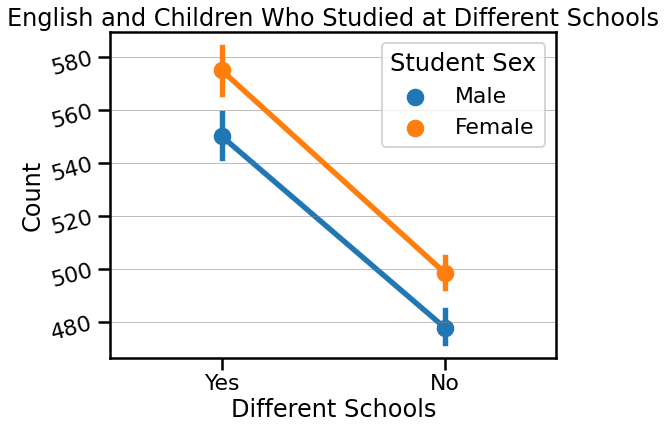

In [32]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='child_studied_at_diff_school', y='english', hue='student_sex', data=df2003)
_ = plt.title('English and Children Who Studied at Different Schools')
_ = plt.xlabel('Different Schools')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

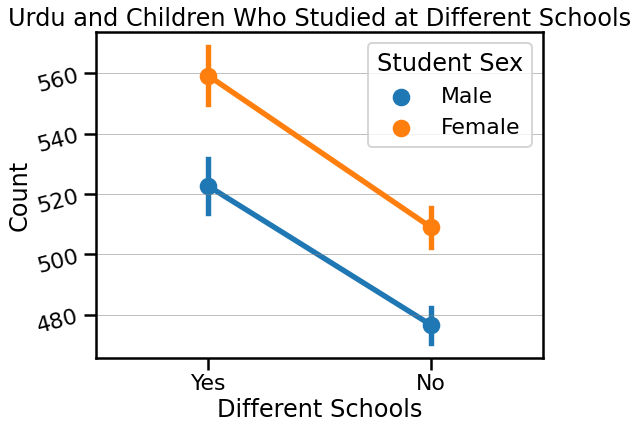

In [33]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='child_studied_at_diff_school', y='urdu', hue='student_sex', data=df2003)
_ = plt.title('Urdu and Children Who Studied at Different Schools')
_ = plt.xlabel('Different Schools')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### A change in school seems almost to have closed the gender gap in math scores but not in Urdu or English.

Yes    465
No     449
Name: own_agri_land_last_2_seasons, dtype: int64

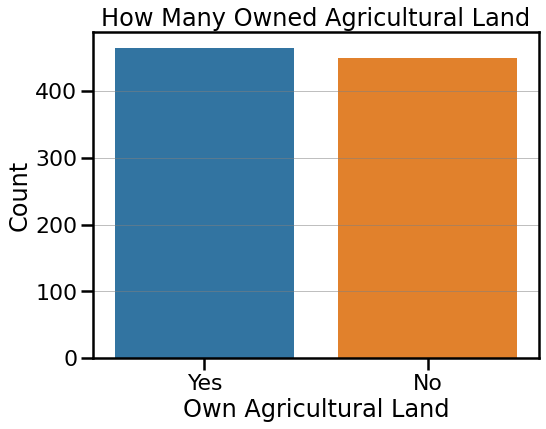

In [34]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='own_agri_land_last_2_seasons', data=df2003)
_ = plt.title('How Many Owned Agricultural Land')
_ = plt.xlabel('Own Agricultural Land')
_ = plt.ylabel('Count')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.own_agri_land_last_2_seasons.value_counts()

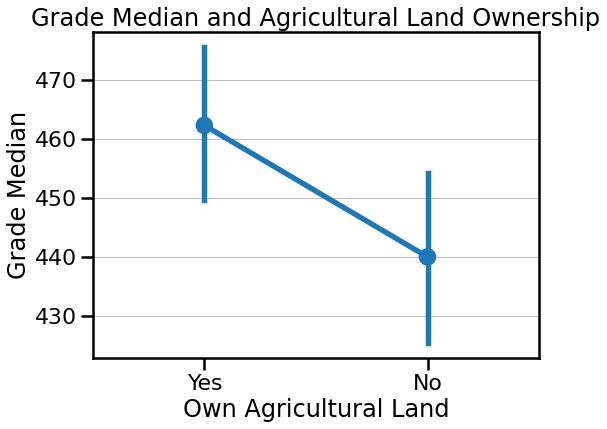

In [35]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='own_agri_land_last_2_seasons', y='grade_median', data=df2003)
_ = plt.title('Grade Median and Agricultural Land Ownership')
_ = plt.xlabel('Own Agricultural Land')
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### About half of those surveyed owned agricultural land, and those with such ownership performed better overall by about 20 points out of 1000, or 1/50.
### The above point plot is made more interesting when one considers that one yearly income and how rich a mauza (area) in which one lives did not significantly affect test scores. Owning agricultural land seems independent of any financial aspect in a household when considering test scores.

No     831
Yes     86
Name: print_have, dtype: int64

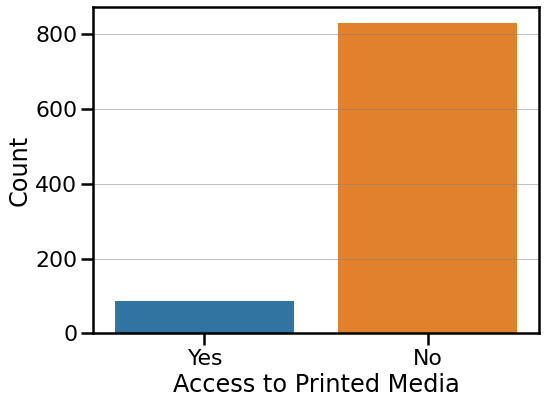

In [36]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='print_have', data=df2003)
_ = plt.xlabel('Access to Printed Media')
_ = plt.ylabel('Count')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.print_have.value_counts()

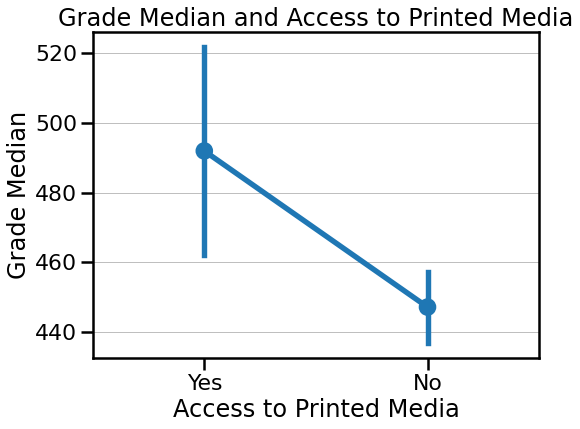

In [37]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='print_have', y='grade_median', data=df2003)
_ = plt.title('Grade Median and Access to Printed Media')
_ = plt.xlabel('Access to Printed Media')
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### Few have access to printed media, and there seems to be a slight, positive correlation between that and grade median.

### Teacher Factors: Educational Qualifications, Sex, Years Teaching, Teacher from Mauza (area)

Matric           5205
F.A./F.SC        3643
B.A./B.SC        2497
M.A. or above     707
<Matric            58
Name: teacher_qualifications, dtype: int64

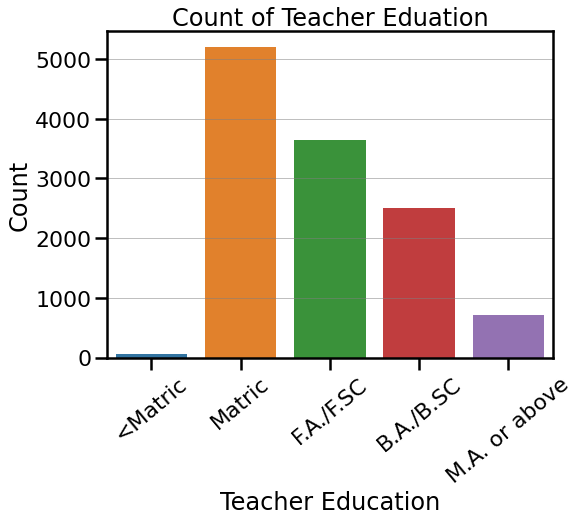

In [38]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='teacher_qualifications', data=df2003)
_ = plt.title('Count of Teacher Eduation')
_ = plt.xlabel('Teacher Education')
_ = plt.xticks(rotation=40)
_ = plt.ylabel('Count')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.teacher_qualifications.value_counts()

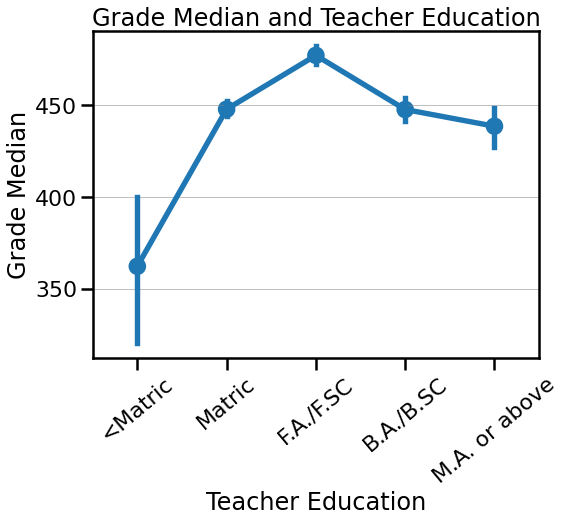

In [39]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_qualifications', y='grade_median',
                  data=df2003)
_ = plt.title('Grade Median and Teacher Education')
_ = plt.xlabel('Teacher Education')
_ = plt.xticks(rotation=40)
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### The technically less qualified "F.A./F.SC" has significantly higher test scores than those with a B.A. or M.A.

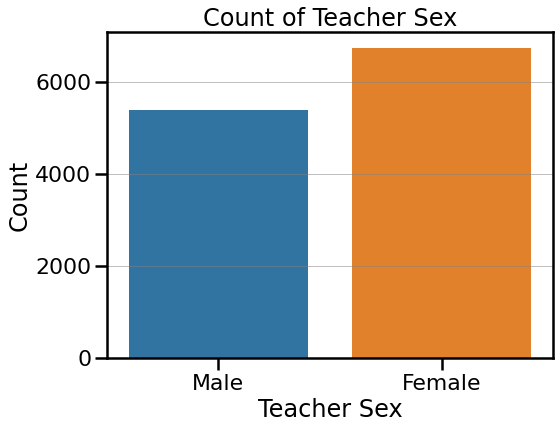

In [40]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='teacher_sex', data=df2003)
_ = plt.title('Count of Teacher Sex')
_ = plt.xlabel('Teacher Sex')
_ = plt.ylabel('Count')

df2003.teacher_sex.value_counts()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

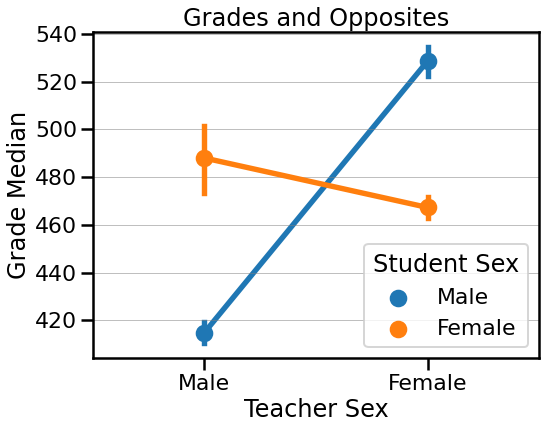

In [41]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_sex', y='grade_median',
                  data=df2003, hue='student_sex')
_ = plt.title('Grades and Opposites')
_ = plt.xlabel('Teacher Sex')
_ = plt.ylabel('Grade Median')
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### Males performed better when taught by female teachers and vice versa, though it is stronger for males.

> 3 Years    8928
1-3 Years    1935
< 1 Year     1247
Name: teacher_years_teaching, dtype: int64

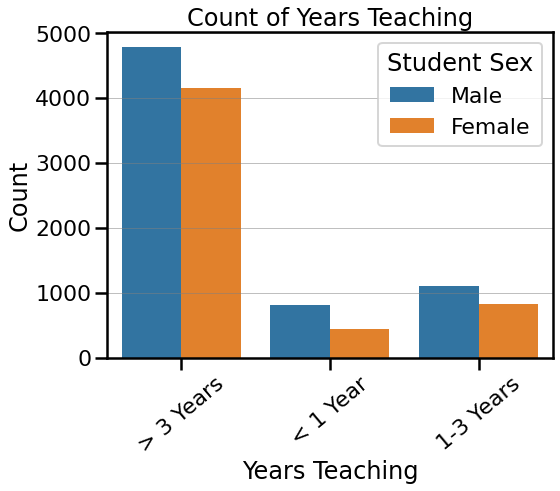

In [42]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='teacher_years_teaching', hue='student_sex',
                  data=df2003)
_ = plt.title('Count of Years Teaching')
_ = plt.xlabel('Years Teaching')
_ = plt.xticks(rotation=40)
_ = plt.ylabel('Count')
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.teacher_years_teaching.value_counts()

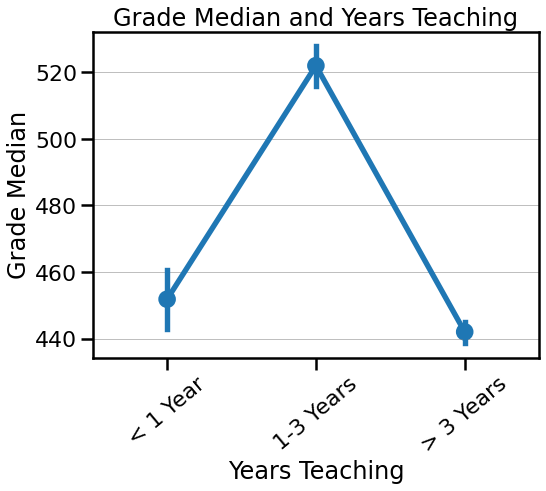

In [43]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_years_teaching', y='grade_median',
                  data=df2003, order=['< 1 Year', '1-3 Years', '> 3 Years'])
_ = plt.title('Grade Median and Years Teaching')
_ = plt.xlabel('Years Teaching')
_ = plt.xticks(rotation=40)
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### Surprisingly, though there is not enough data on teachers who have taught for less than one year, teachers with the most experience have the lowest grades. Whatever explanation is put forward, it must consider the overwhelming amount of teachers with more than 3 years of teaching.

No     7763
Yes    4347
Name: teacher_from_mauza, dtype: int64

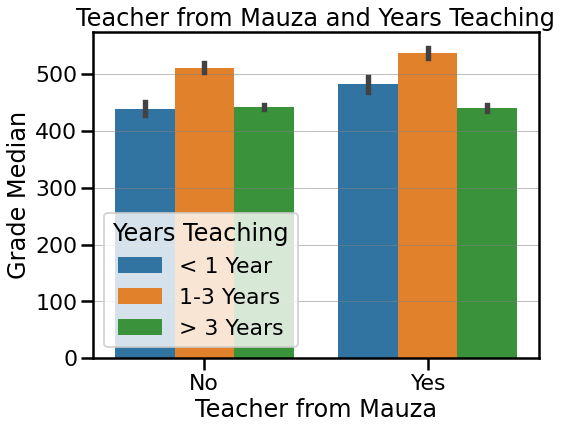

In [44]:
_ = plt.figure(figsize=(8, 6))
_ = sns.barplot(x='teacher_from_mauza', y='grade_median',
                  data=df2003, hue='teacher_years_teaching',
                   hue_order=['< 1 Year', '1-3 Years', '> 3 Years'])
_ = plt.title('Teacher from Mauza and Years Teaching')
_ = plt.xlabel('Teacher from Mauza')
_ = plt.ylabel('Grade Median')
_ = plt.legend(title='Years Teaching')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.teacher_from_mauza.value_counts()

No     7763
Yes    4347
Name: teacher_from_mauza, dtype: int64

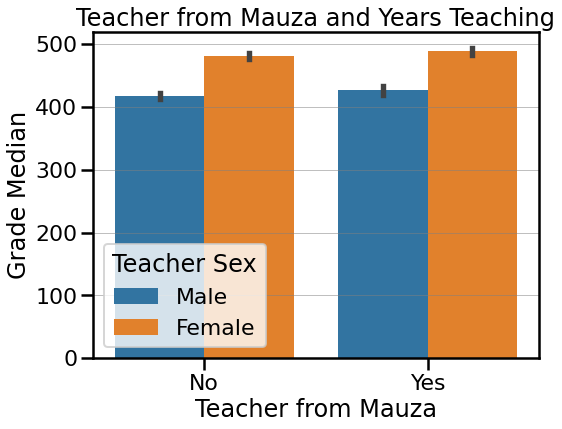

In [45]:
_ = plt.figure(figsize=(8, 6))
_ = sns.barplot(x='teacher_from_mauza', y='grade_median',
                  data=df2003, hue='teacher_sex')
_ = plt.title('Teacher from Mauza and Years Teaching')
_ = plt.xlabel('Teacher from Mauza')
_ = plt.ylabel('Grade Median')
_ = plt.legend(title='Teacher Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.teacher_from_mauza.value_counts()

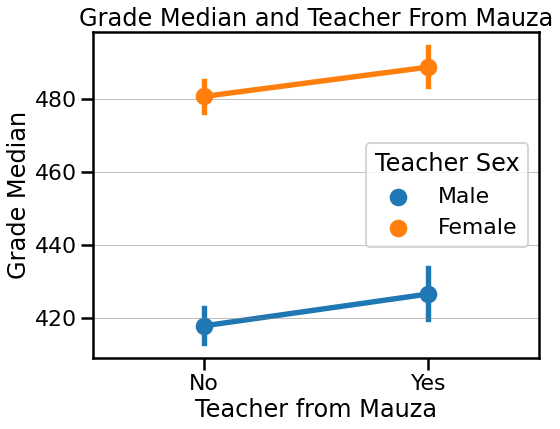

In [46]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_from_mauza', y='grade_median',
                  data=df2003, hue='teacher_sex')
_ = plt.title('Grade Median and Teacher From Mauza')
_ = plt.xlabel('Teacher from Mauza')
_ = plt.ylabel('Grade Median')
_ = plt.legend(title='Teacher Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

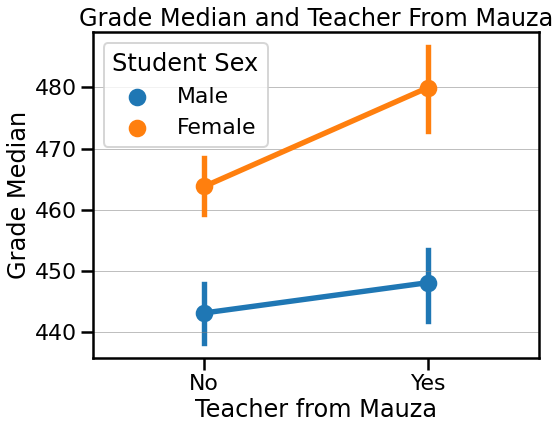

In [47]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_from_mauza', y='grade_median',
                  data=df2003, hue='student_sex')
_ = plt.title('Grade Median and Teacher From Mauza')
_ = plt.xlabel('Teacher from Mauza')
_ = plt.ylabel('Grade Median')
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### Female teachers who remain in their mauza of being raised have higher scoring female students than male students.
### Female students benefit more from a teacher remaining in a mauza than male students.

## 2004

In [48]:
df2004.head(3)

grade_median  childcode  hhid  teachercode  child_teachercode student_sex  \
0         620.0     101001   NaN      10103.0            10103.0        Male   
1         725.0     101002   NaN      10205.0            10103.0        Male   
2         630.0     101003   NaN      10351.0            10103.0      Female   

   english   math   urdu  grade  ...  teacher_survey_absent_other_work  \
0    716.0  620.0  611.0    4.0  ...                               Yes   
1    743.0  725.0  637.0    4.0  ...                                No   
2    726.0  630.0  645.0    4.0  ...                                No   

   teacher_years_teaching  teacher_training teacher_qualifications  \
0                < 1 Year       No training                 FA/FSc   
1               > 3 Years         PTC/JV/SV                 Matric   
2                < 1 Year       No training                 Matric   

  teacher_from_mauza child_studied_at_diff_school radio television  \
0                Yes                           No   Yes         No   
1                Yes                           No   Yes        Yes   
2                Yes                           No   Yes        Yes   

  child_days_absent_last_mo teacher_rates_child_how_good_in_studies  
0                       NaN                                     NaN  
1                       0.0                                     5.0  
2                       0.0                                     6.0  

[3 rows x 30 columns]

In [49]:
df2004.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64218 entries, 0 to 109147
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   grade_median                             64218 non-null  float64 
 1   childcode                                64218 non-null  int32   
 2   hhid                                     52310 non-null  float64 
 3   teachercode                              454 non-null    float64 
 4   child_teachercode                        64218 non-null  float64 
 5   student_sex                              64218 non-null  category
 6   english                                  64218 non-null  float64 
 7   math                                     64218 non-null  float64 
 8   urdu                                     64218 non-null  float64 
 9   grade                                    64218 non-null  float64 
 10  supervisor_code                  

64218

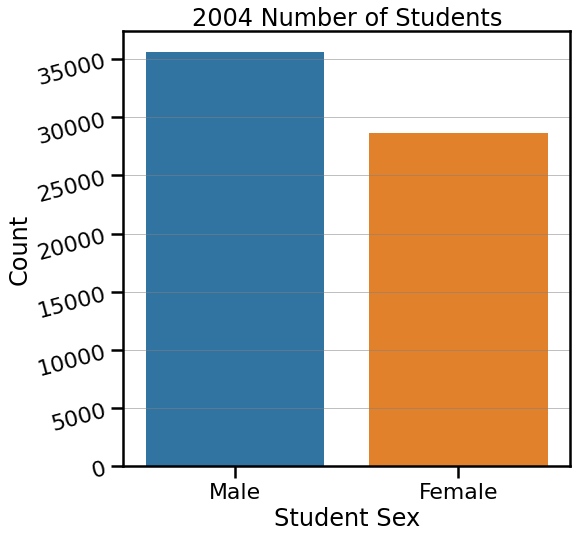

In [50]:
_ = plt.figure(figsize=(8, 8))
_ = sns.countplot(x='student_sex', data=df2004, order=['Male', 'Female'])
_ = plt.title('2004 Number of Students')
_ = plt.xlabel('Student Sex')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2004.grade_median.value_counts().sum()

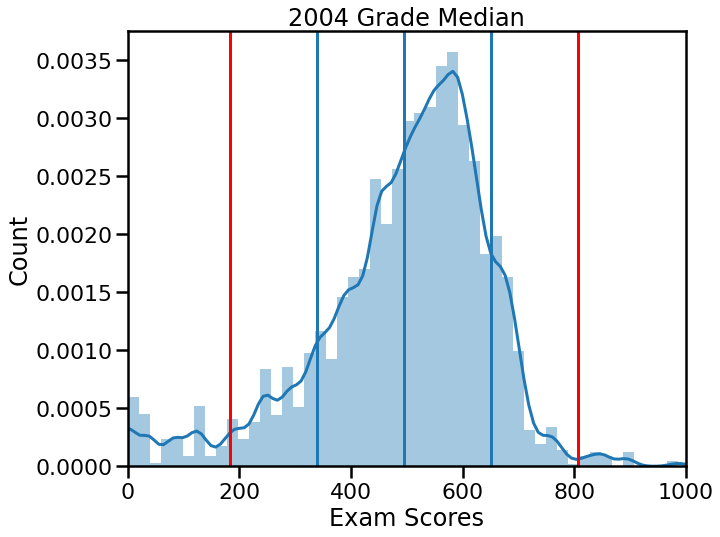

In [51]:
_ = plt.figure(figsize=(10, 8))
_ = sns.distplot(df2004.grade_median)
_ = plt.axvline(np.mean(df2004.grade_median) + np.std(df2004.grade_median))
_ = plt.axvline(np.mean(df2004.grade_median) + 2 * np.std(df2004.grade_median), c='r')
_ = plt.axvline(np.mean(df2004.grade_median) - np.std(df2004.grade_median))
_ = plt.axvline(np.mean(df2004.grade_median) - 2 * np.std(df2004.grade_median), c='r')
_ = plt.axvline(np.mean(df2004.grade_median))
_ = plt.xlim(0, 1000)
_ = plt.title('2004 Grade Median')
_ = plt.xlabel('Exam Scores')
_ = plt.ylabel('Count')

22.0    23438
11.0    15293
16.0    13576
Name: supervisor_code, dtype: int64

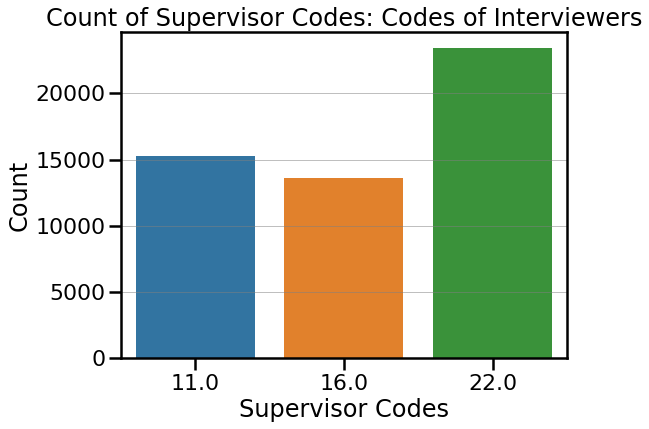

In [52]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='supervisor_code', data=df2004)
_ = plt.title('Count of Supervisor Codes: Codes of Interviewers')
_ = plt.xlabel('Supervisor Codes')
_ = plt.ylabel('Count')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2004.supervisor_code.value_counts()

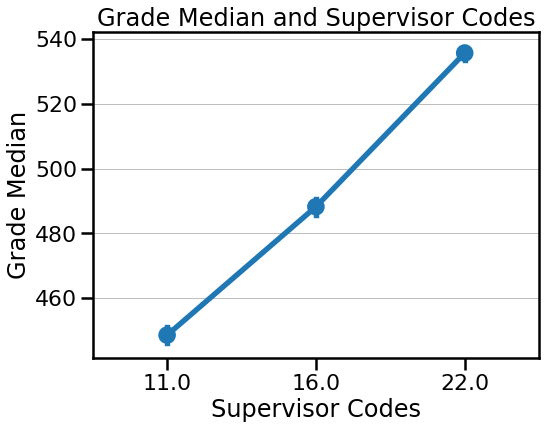

In [53]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='supervisor_code', y='grade_median', data=df2004)
_ = plt.title('Grade Median and Supervisor Codes')
_ = plt.xlabel('Supervisor Codes')
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### There is somehow a significant correlation between the code of supervisors and the grade median. This may be related to how the data was gathered.

No           42097
No Answer    11948
Yes          10173
Name: hh_child_in_govt_primary_school, dtype: int64

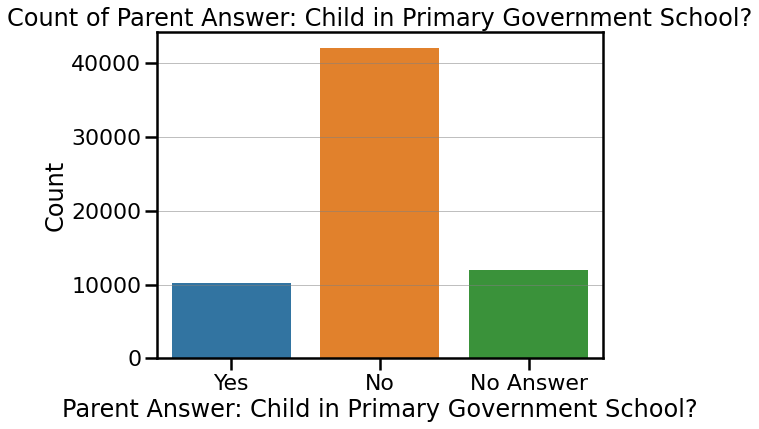

In [54]:
# Convert 1.0 and 2.0 to No and Yes, respectively.
df2004_govt = df2004.copy()
df2004_govt.hh_child_in_govt_primary_school = df2004_govt.hh_child_in_govt_primary_school.fillna(55.0)
num_to_yes_no = {1.0: 'No', 2.0: 'Yes', 55.0: 'No Answer'}
df2004_govt.hh_child_in_govt_primary_school = [num_to_yes_no[item] for item in df2004_govt.hh_child_in_govt_primary_school]

_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='hh_child_in_govt_primary_school', data=df2004_govt,
                 order = ['Yes', 'No', 'No Answer'])
_ = plt.title('Count of Parent Answer: Child in Primary Government School?')
_ = plt.xlabel('Parent Answer: Child in Primary Government School?')
_ = plt.ylabel('Count')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2004_govt.hh_child_in_govt_primary_school.value_counts()

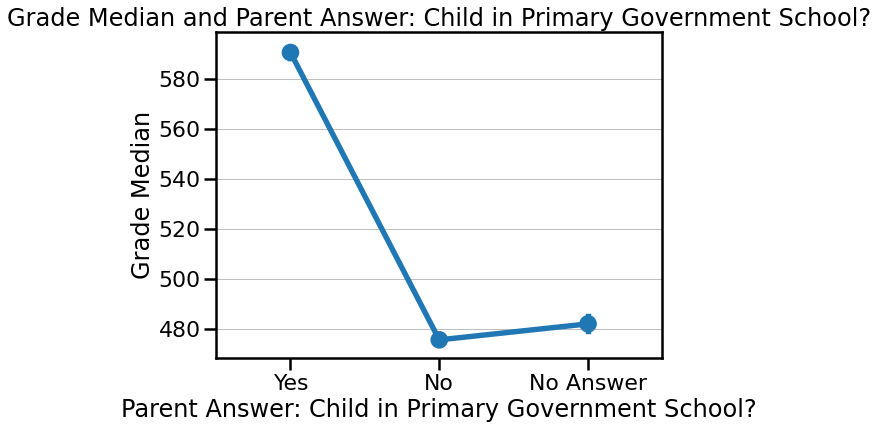

In [55]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='hh_child_in_govt_primary_school', y='grade_median', data=df2004_govt,
                 order = ['Yes', 'No', 'No Answer'])
_ = plt.title('Grade Median and Parent Answer: Child in Primary Government School?')
_ = plt.xlabel('Parent Answer: Child in Primary Government School?')
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

English             855
Math                229
Urdu                 81
Islimaiyat/Quran     54
Science Subjects     48
Name: child_helped, dtype: int64

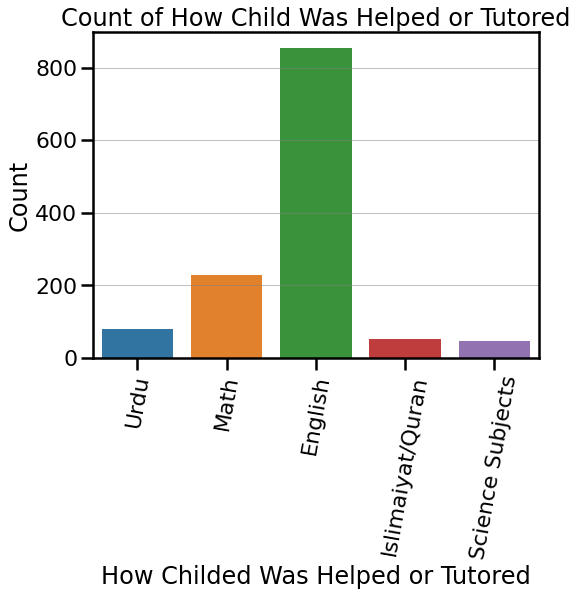

In [56]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='child_helped', data=df2004)
_ = plt.title('Count of How Child Was Helped or Tutored')
_ = plt.xticks(rotation=80)
_ = plt.xlabel('How Childed Was Helped or Tutored')
_ = plt.ylabel('Count')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2004.child_helped.value_counts()

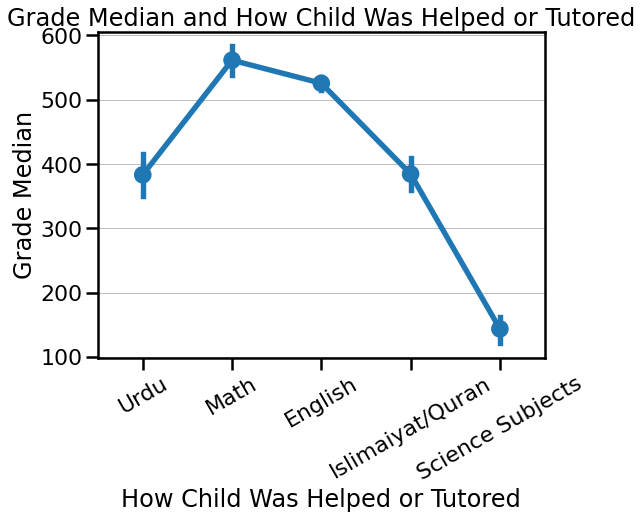

In [57]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='child_helped', y='grade_median', data=df2004)
_ = plt.title('Grade Median and How Child Was Helped or Tutored')
_ = plt.xlabel('How Child Was Helped or Tutored')
_ = plt.xticks(rotation=30)
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

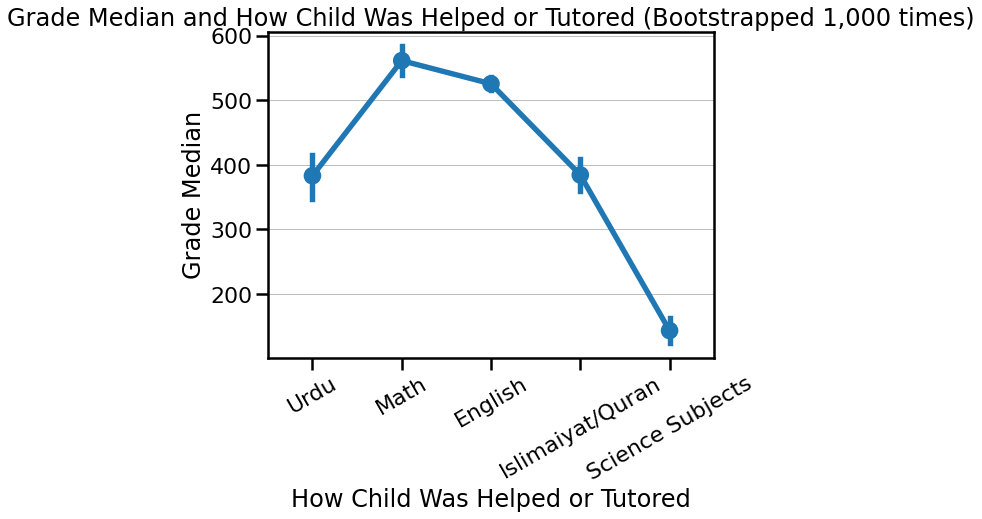

In [58]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='child_helped', y='grade_median', data=df2004, n_boot=1000)
_ = plt.title('Grade Median and How Child Was Helped or Tutored (Bootstrapped 1,000 times)')
_ = plt.xlabel('How Child Was Helped or Tutored')
_ = plt.xticks(rotation=30)
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### There is only enough data to show that English and Math tutoring are helpful, though all but science look promising.

English             855
Math                229
Urdu                 81
Islimaiyat/Quran     54
Science Subjects     48
Name: child_helped, dtype: int64

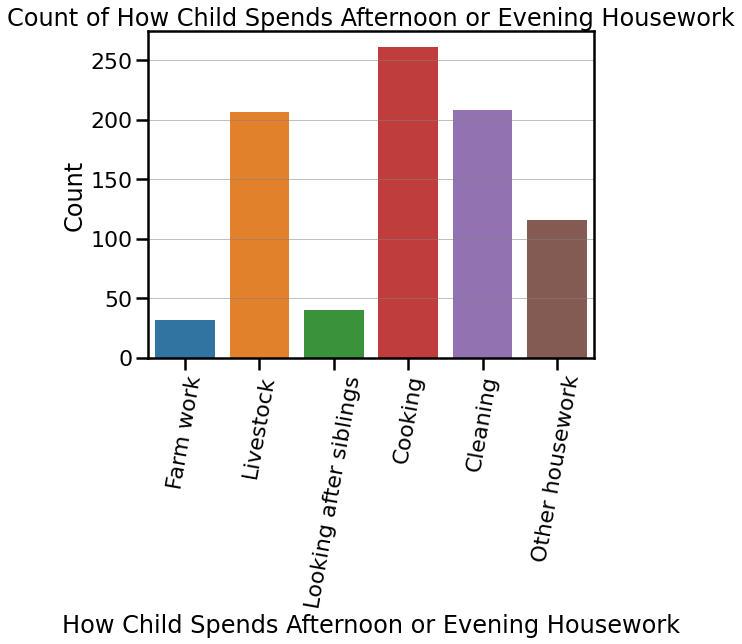

In [59]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='type_of_housework_timeslot_5', data=df2004)
_ = plt.title('Count of How Child Spends Afternoon or Evening Housework')
_ = plt.xticks(rotation=80)
_ = plt.xlabel('How Child Spends Afternoon or Evening Housework')
_ = plt.ylabel('Count')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2004.child_helped.value_counts()

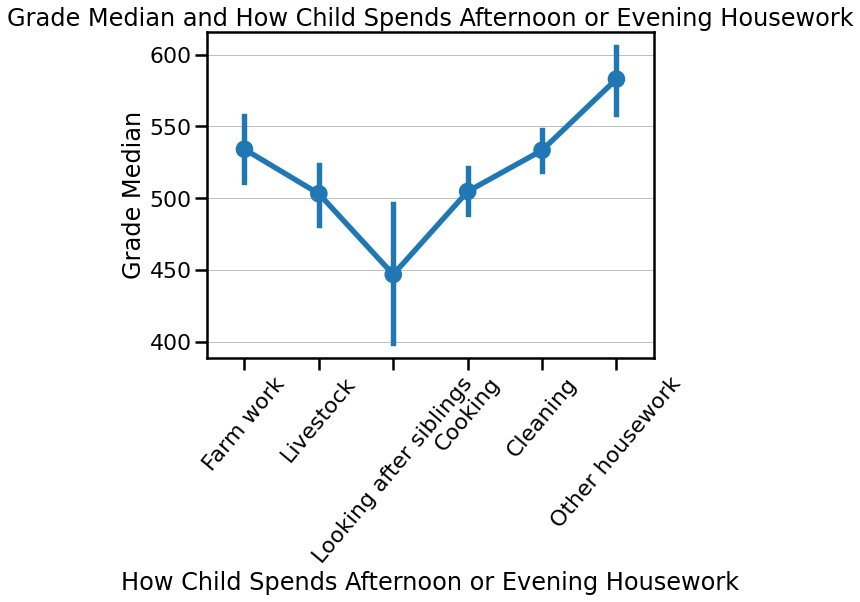

In [60]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='type_of_housework_timeslot_5', y='grade_median', data=df2004)
_ = plt.title('Grade Median and How Child Spends Afternoon or Evening Housework')
_ = plt.xlabel('How Child Spends Afternoon or Evening Housework')
_ = plt.xticks(rotation=50)
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

7.0     6878
8.0     6866
5.0     6725
9.0     5291
6.0     4945
4.0     4196
10.0    3439
3.0     2218
2.0     1844
1.0     1445
0.0      685
Name: teacher_rates_child_how_good_in_studies, dtype: int64

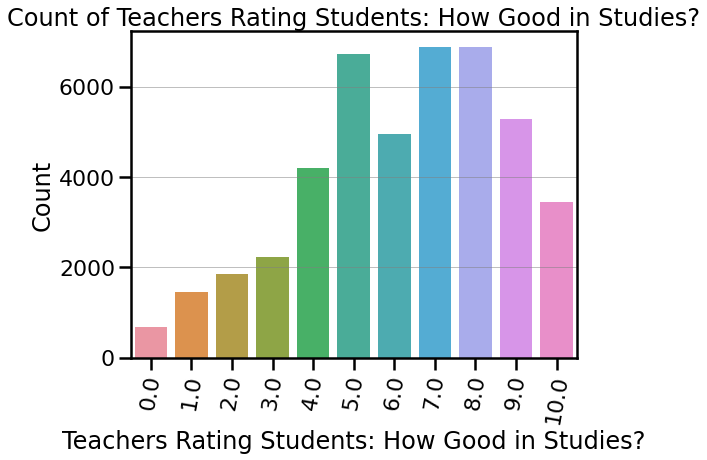

In [61]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='teacher_rates_child_how_good_in_studies', data=df2004)
_ = plt.title('Count of Teachers Rating Students: How Good in Studies?')
_ = plt.xticks(rotation=80)
_ = plt.xlabel('Teachers Rating Students: How Good in Studies?')
_ = plt.ylabel('Count')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2004.teacher_rates_child_how_good_in_studies.value_counts()

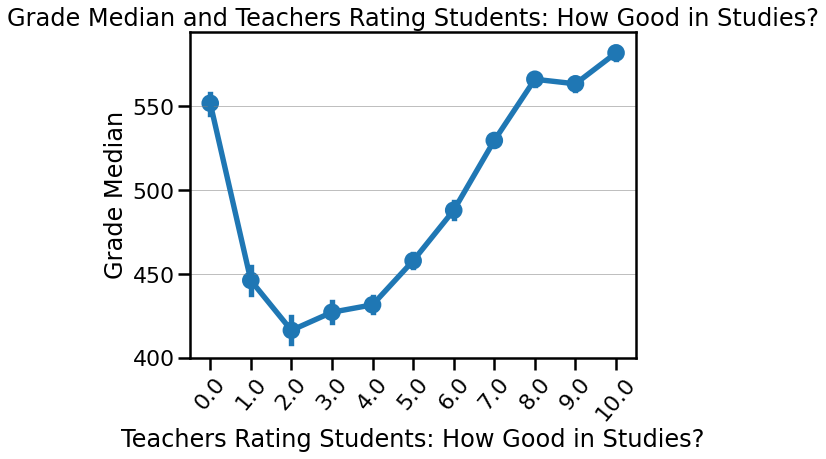

In [62]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_rates_child_how_good_in_studies', y='grade_median', data=df2004)
_ = plt.title('Grade Median and Teachers Rating Students: How Good in Studies?')
_ = plt.xlabel('Teachers Rating Students: How Good in Studies?')
_ = plt.xticks(rotation=50)
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### Aside from the odd peak with 689 students who were rated at bottom, this holds with the 2003 dataset.

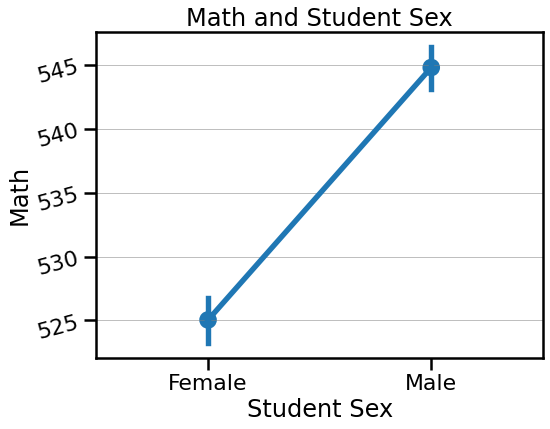

In [63]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='student_sex', y='math', data=df2004)
_ = plt.title('Math and Student Sex')
_ = plt.xlabel('Student Sex')
_ = plt.ylabel('Math')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

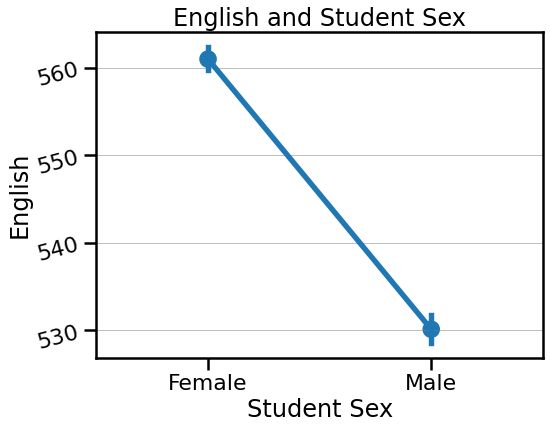

In [64]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='student_sex', y='english', data=df2004)
_ = plt.title('English and Student Sex')
_ = plt.xlabel('Student Sex')
_ = plt.ylabel('English')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

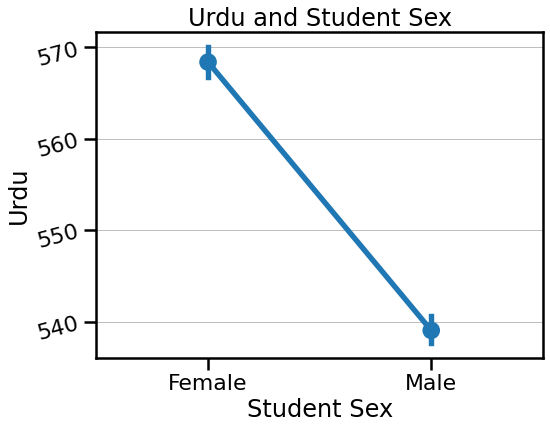

In [65]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='student_sex', y='urdu', data=df2004)
_ = plt.title('Urdu and Student Sex')
_ = plt.xlabel('Student Sex')
_ = plt.ylabel('Urdu')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### As in 2003, males perform better in math while females perform better in English and Urdu

Yes    18399
No       972
Name: studied_at_same_school_as_last_year, dtype: int64

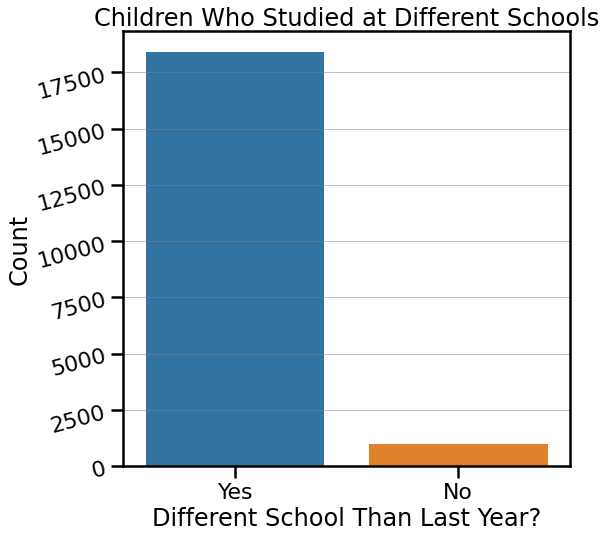

In [66]:
_ = plt.figure(figsize=(8, 8))
_ = sns.countplot(x='studied_at_same_school_as_last_year', data=df2004)
_ = plt.title('Children Who Studied at Different Schools')
_ = plt.xlabel('Different School Than Last Year?')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2004.studied_at_same_school_as_last_year.value_counts()

### The 2004 dataset has many more students who have switched schools than the 2003 dataset.

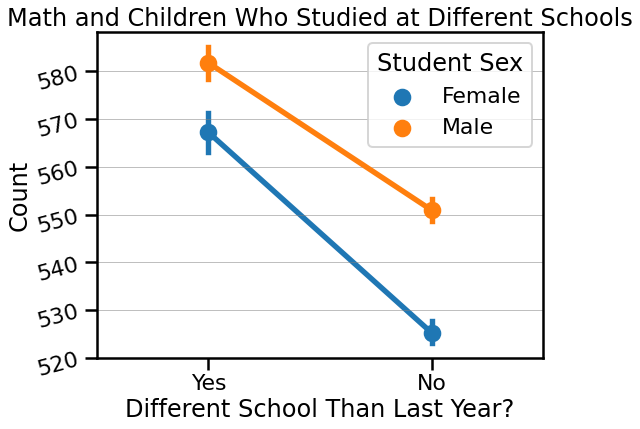

In [67]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='child_studied_at_diff_school', y='math', hue='student_sex', data=df2004)
_ = plt.title('Math and Children Who Studied at Different Schools')
_ = plt.xlabel('Different School Than Last Year?')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

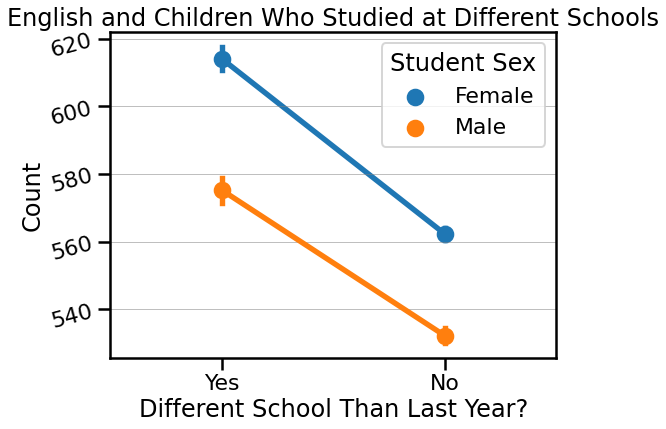

In [68]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='child_studied_at_diff_school', y='english', hue='student_sex', data=df2004)
_ = plt.title('English and Children Who Studied at Different Schools')
_ = plt.xlabel('Different School Than Last Year?')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

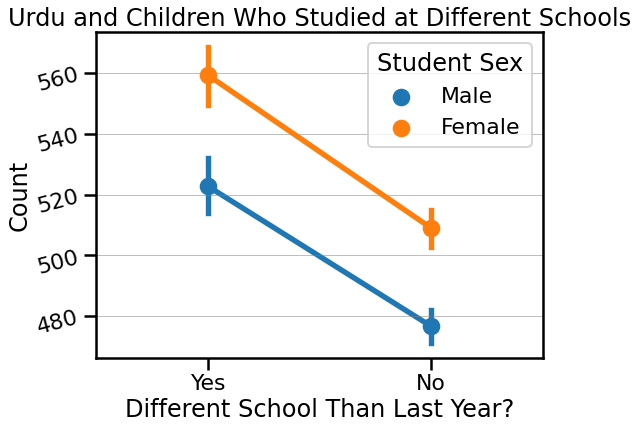

In [69]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='child_studied_at_diff_school', y='urdu', hue='student_sex', data=df2003)
_ = plt.title('Urdu and Children Who Studied at Different Schools')
_ = plt.xlabel('Different School Than Last Year?')
_ = plt.ylabel('Count')
_ = plt.yticks(rotation=15)
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### Unlike in 2003, changing schools does not close the math gap between males and females, though it is still correlated with a significant improvement for both sexes in all subjects.

Yes    28199
No     16230
Name: radio, dtype: int64

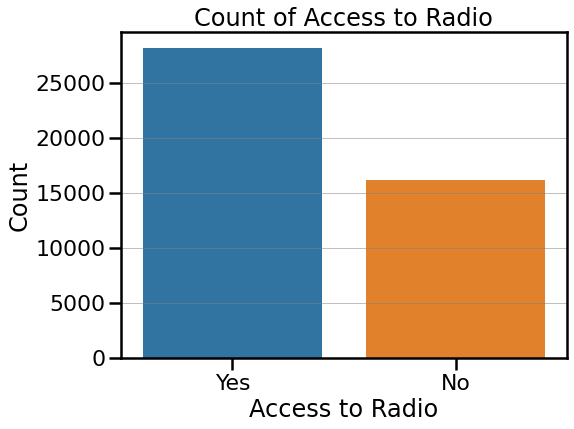

In [70]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='radio', data=df2004)
_ = plt.title('Count of Access to Radio')
_ = plt.xlabel('Access to Radio')
_ = plt.ylabel('Count')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2004.radio.value_counts()

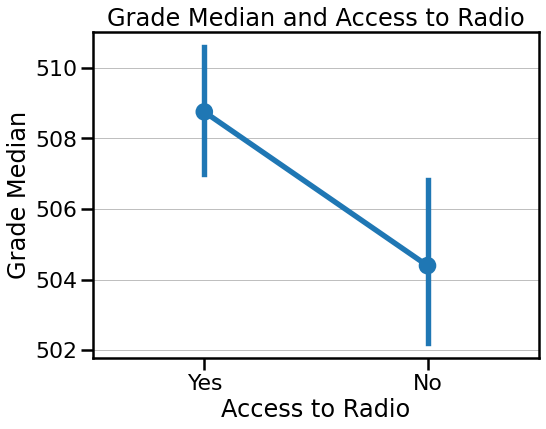

In [71]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='radio', y='grade_median', data=df2004)
_ = plt.title('Grade Median and Access to Radio')
_ = plt.xlabel('Access to Radio')
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

Yes    28059
No     16370
Name: television, dtype: int64

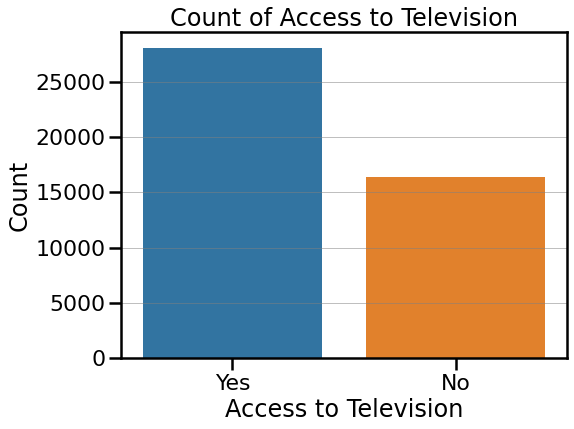

In [72]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='television', data=df2004)
_ = plt.title('Count of Access to Television')
_ = plt.xlabel('Access to Television')
_ = plt.ylabel('Count')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2004.television.value_counts()

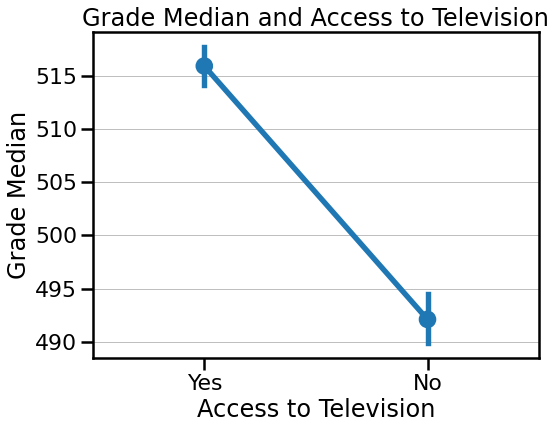

In [73]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='television', y='grade_median', data=df2004)
_ = plt.title('Grade Median and Access to Television')
_ = plt.xlabel('Access to Television')
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### Many do and do not have access to radio and television. Radio hardly has a correlation with the grade median, though television has a significant positive correlation.

### Teacher Factors: Educational Qualifications, Sex, Years Teaching, Teacher from Mauza (area)

Matric           5205
F.A./F.SC        3643
B.A./B.SC        2497
M.A. or above     707
<Matric            58
Name: teacher_qualifications, dtype: int64

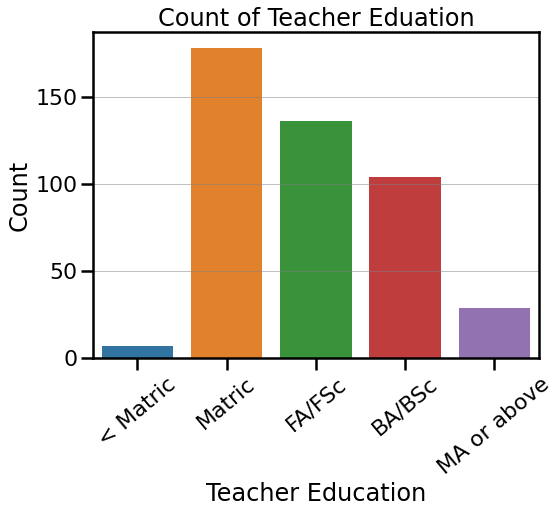

In [74]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='teacher_qualifications', data=df2004)
_ = plt.title('Count of Teacher Eduation')
_ = plt.xlabel('Teacher Education')
_ = plt.xticks(rotation=40)
_ = plt.ylabel('Count')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.teacher_qualifications.value_counts()

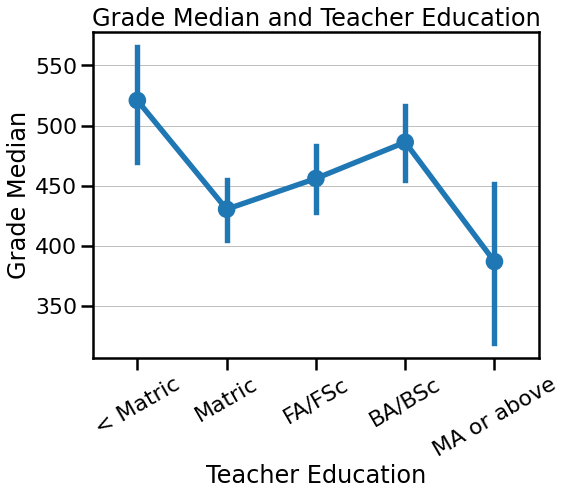

In [75]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_qualifications', y='grade_median',
                  data=df2004)
_ = plt.title('Grade Median and Teacher Education')
_ = plt.xlabel('Teacher Education')
_ = plt.xticks(rotation=30)
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

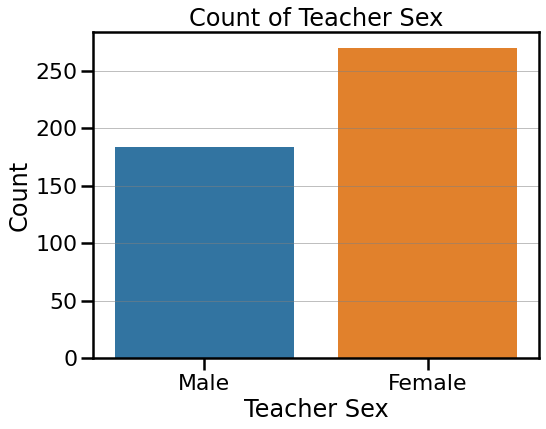

In [76]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='teacher_sex', data=df2004)
_ = plt.title('Count of Teacher Sex')
_ = plt.xlabel('Teacher Sex')
_ = plt.ylabel('Count')

df2003.teacher_sex.value_counts()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

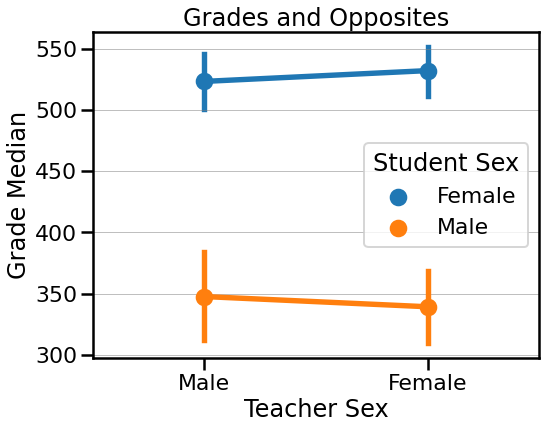

In [77]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_sex', y='grade_median',
                  data=df2004, hue='student_sex')
_ = plt.title('Grades and Opposites')
_ = plt.xlabel('Teacher Sex')
_ = plt.ylabel('Grade Median')
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### Unlike the data from 2003, there is no correlation between the sex of a student and teacher.

> 3 Years    8928
1-3 Years    1935
< 1 Year     1247
Name: teacher_years_teaching, dtype: int64

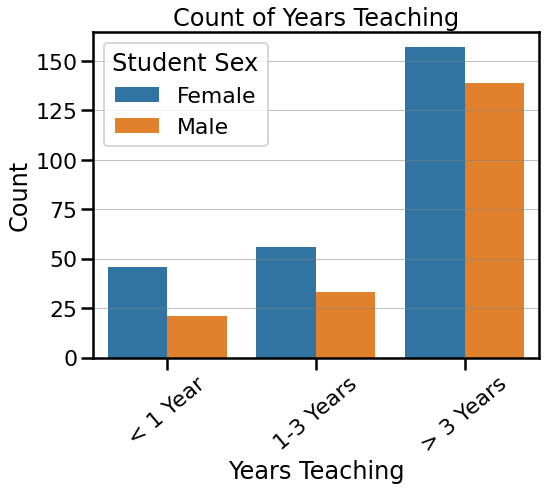

In [78]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='teacher_years_teaching', hue='student_sex',
                  data=df2004)
_ = plt.title('Count of Years Teaching')
_ = plt.xlabel('Years Teaching')
_ = plt.xticks(rotation=40)
_ = plt.ylabel('Count')
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.teacher_years_teaching.value_counts()

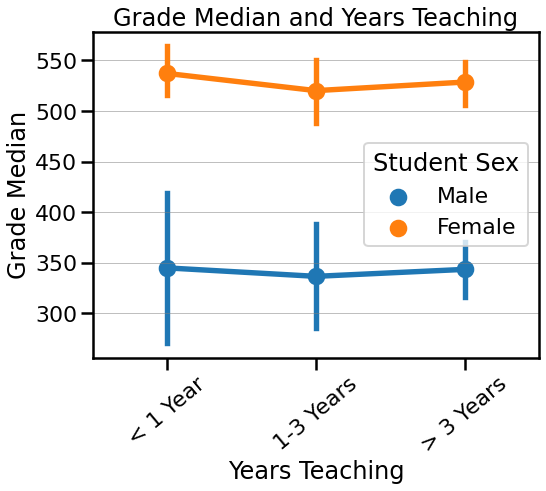

In [79]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_years_teaching', y='grade_median',
                  data=df2004, hue='student_sex', order=['< 1 Year', '1-3 Years', '> 3 Years'],
                 hue_order=['Male', 'Female'])
_ = plt.title('Grade Median and Years Teaching')
_ = plt.xlabel('Years Teaching')
_ = plt.xticks(rotation=40)
_ = plt.ylabel('Grade Median')
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### Unlike data from 2003, there is no correlation between the grade of students and the years a teacher has been teaching.

No     7763
Yes    4347
Name: teacher_from_mauza, dtype: int64

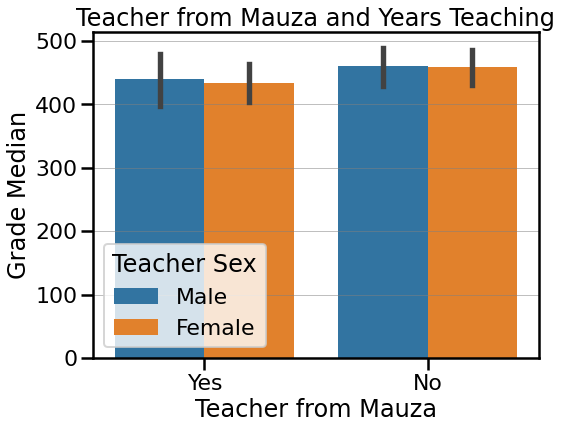

In [80]:
_ = plt.figure(figsize=(8, 6))
_ = sns.barplot(x='teacher_from_mauza', y='grade_median',
                  data=df2004, hue='teacher_sex')
_ = plt.title('Teacher from Mauza and Years Teaching')
_ = plt.xlabel('Teacher from Mauza')
_ = plt.ylabel('Grade Median')
_ = plt.legend(title='Teacher Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2003.teacher_from_mauza.value_counts()

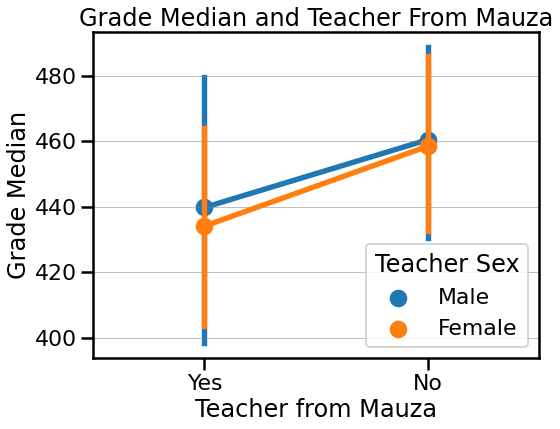

In [81]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_from_mauza', y='grade_median',
                  data=df2004, hue='teacher_sex')
_ = plt.title('Grade Median and Teacher From Mauza')
_ = plt.xlabel('Teacher from Mauza')
_ = plt.ylabel('Grade Median')
_ = plt.legend(title='Teacher Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

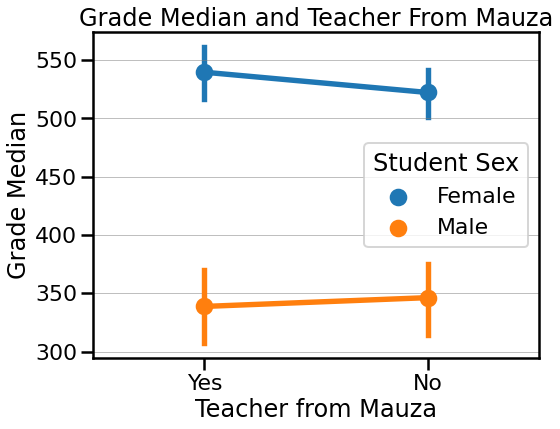

In [82]:
_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='teacher_from_mauza', y='grade_median',
                  data=df2004, hue='student_sex')
_ = plt.title('Grade Median and Teacher From Mauza')
_ = plt.xlabel('Teacher from Mauza')
_ = plt.ylabel('Grade Median')
_ = plt.legend(title='Student Sex')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### Unlike the 2003 dataset, there is not much of any correlation between grades and whether a teacher is from a mauza, except that females seem to benefit more from having a teacher from the same mauza than vice versa.

In [83]:
# drop the category "Madrassa" because it only had 4 instances.
df2004.school_type.cat.remove_categories(removals=['Madrassa'], inplace=True)

Public     14455
Private     4916
Name: school_type, dtype: int64

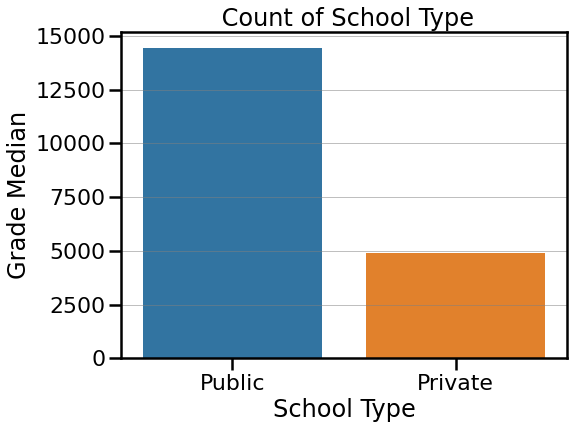

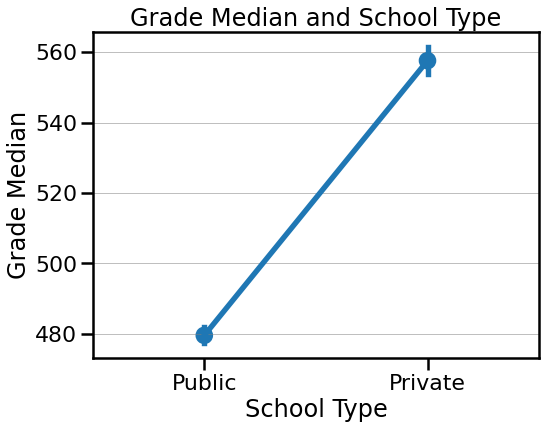

In [84]:
_ = plt.figure(figsize=(8, 6))
_ = sns.countplot(x='school_type', data=df2004)
_ = plt.title(' Count of School Type')
_ = plt.xlabel('School Type')
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

_ = plt.figure(figsize=(8, 6))
_ = sns.pointplot(x='school_type', y='grade_median', data=df2004)
_ = plt.title('Grade Median and School Type')
_ = plt.xlabel('School Type')
_ = plt.ylabel('Grade Median')
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

df2004.school_type.value_counts()

# Back to Data Cleaning

## Convert strings to integers

### I performed this after the Cleaning Data section in order to make more intuitive graphs.

In [85]:
df2003['teacher_years_teaching'] = df2003['teacher_years_teaching'].astype('category')
df2003['teacher_training'] = df2003['teacher_training'].astype('category')
df2003['teacher_from_mauza'] = df2003['teacher_from_mauza'].astype('category')

In [86]:
cat_columns_03 = df2003.select_dtypes(['category']).columns
df2003[cat_columns_03] = df2003[cat_columns_03].apply(lambda x: x.cat.codes)

# Fill NaNs with 99
# Remember that the data I am filling was intentionally left empty by the data-collecting scholars;
# there is no intent that these NaNs be anything ofther than NaNs.
df2003 = df2003.fillna(99)

In [87]:
cat_columns_04 = df2004.select_dtypes(['category']).columns
df2004[cat_columns_04] = df2004[cat_columns_04].apply(lambda x: x.cat.codes)

# Fill NaNs with 99
# Remember that the data I am filling was intentionally left empty by the data-collecting scholars;
# there is no intent that these NaNs be anything ofther than NaNs.
df2004 = df2004.fillna(99)

In [88]:
# Here, I fill NaN values with the lesser observed sex: females.
imr = SimpleImputer(strategy='constant', fill_value=0)
imr = imr.fit(df2004[['student_sex']])
df2004.student_sex = imr.transform(df2004[['student_sex']]).ravel()

### Let's minimize dtypes and make sure df2003 and df2004 have no category data types or NaNs

In [89]:
df2003.grade_median = df2003.grade_median.astype('int16')
df2003.hhid = df2003.hhid.astype('int16')
df2003.teacher_rates_child_how_good_in_studies = df2003.teacher_rates_child_how_good_in_studies.astype('int8')
df2003.salary_monthly_Rs = df2003.salary_monthly_Rs.astype('int16')
df2003.mauzaid = df2003.mauzaid.astype('int16')
df2003.teacher_days_absent_last_mo = df2003.teacher_days_absent_last_mo.astype('int8')

In [90]:
print(f'df2003 data types:\n{df2003.dtypes} \n\n\
No NaNs or "None" objects:\n{df2003.isna().sum()}')

df2003 data types:
grade_median                                 int16
childcode                                    int32
hhid                                         int16
child_teachercode                            int32
child_schoolid1                               int8
english                                    float64
urdu                                       float64
math                                       float64
student_sex                                   int8
grade                                         int8
teacher_rates_child_how_good_in_studies       int8
child_studied_at_diff_school                  int8
teacher_sex                                   int8
teacher_years_teaching                        int8
teacher_qualifications                        int8
teacher_training                              int8
salary_monthly_Rs                            int16
teacher_from_mauza                            int8
teacher_days_absent_last_mo                   int8
mauzaid     

In [91]:
df2004.teacher_rates_child_how_good_in_studies.max()

99.0

In [92]:
df2004.grade_median = df2004.grade_median.astype('int16')
df2004.hhid = df2004.hhid.astype('int32')
df2004.teachercode = df2004.teachercode.astype('int32')
df2004.child_teachercode = df2004.child_teachercode.astype('int32')
df2004.english = df2004.english.astype('int16')
df2004.math = df2004.math.astype('int16')
df2004.urdu = df2004.urdu.astype('int16')
df2004.grade = df2004.grade.astype('int8')
df2004.supervisor_code = df2004.supervisor_code.astype('int8')
df2004.hh_child_in_govt_primary_school = df2004.hh_child_in_govt_primary_school.astype('int8')
df2004.tehsil_census_code = df2004.tehsil_census_code.astype('int16')
df2004.child_days_absent_last_mo = df2004.child_days_absent_last_mo.astype('int8')
df2004.teacher_rates_child_how_good_in_studies = df2004.teacher_rates_child_how_good_in_studies.astype('int8')

In [93]:
print(f'df2004 data types:\n{df2004.dtypes} \n\n\
No NaNs or "None" objects:\n{df2004.isna().sum()}')

df2004 data types:
grade_median                               int16
childcode                                  int32
hhid                                       int32
teachercode                                int32
child_teachercode                          int32
student_sex                                 int8
english                                    int16
math                                       int16
urdu                                       int16
grade                                       int8
supervisor_code                             int8
hh_child_in_govt_primary_school             int8
tehsil_census_code                         int16
school_type                                 int8
studied_at_same_school_as_last_year         int8
child_helped                                int8
type_of_housework_timeslot_5                int8
teacher_sex                                 int8
teacher_survey_absent_emergency             int8
teacher_survey_absent_office_work           int8
t

# Outliers

## Interquartile Range

In [94]:
# df2003 iqr
Q1 = df2003.grade_median.quantile(0.25)
Q3 = df2003.grade_median.quantile(0.75)
IQR = Q3 - Q1
print(f'df2003.grade_median:\n    Q1: {Q1}\n    Q3: {Q3}\n    IQR: {IQR}')

# df2004 iqr
Q1 = df2004.grade_median.quantile(0.25)
Q3 = df2004.grade_median.quantile(0.75)
IQR = Q3 - Q1
print(f'\ndf2004.grade_median:\n    Q1:{Q1}\n    Q3:{Q3}\n    IQR:{IQR}')

df2003.grade_median:
    Q1: 352.0
    Q3: 570.75
    IQR: 218.75

df2004.grade_median:
    Q1:418.0
    Q3:598.0
    IQR:180.0


## After seeing the general scope of the data, the numbers and boxplots below show that each year of grades has an irregular bell curve. There are many more instances below two standard deviations than above them.

In [95]:
std_pos2 = df2003.grade_median[df2003.grade_median > (np.mean(df2003.grade_median + (2 * np.std(df2003.grade_median))))].count()
std_neg2 = df2003.grade_median[df2003.grade_median > (np.mean(df2003.grade_median - (2 * np.std(df2003.grade_median))))].count()
print(f'2003: Instances Two STDs above: {std_pos2}\n2003: Instances Two STDs below: {std_neg2}')

2003: Instances Two STDs above: 46
2003: Instances Two STDs below: 11775


In [96]:
std_pos2 = df2004.grade_median[df2004.grade_median > (np.mean(df2004.grade_median + (2 * np.std(df2004.grade_median))))].count()
std_neg2 = df2004.grade_median[df2004.grade_median > (np.mean(df2004.grade_median - (2 * np.std(df2004.grade_median))))].count()
print(f'2004: Instances Two STDs above: {std_pos2}\n2004: Instances Two STDs below: {std_neg2}')

2004: Instances Two STDs above: 611
2004: Instances Two STDs below: 61049


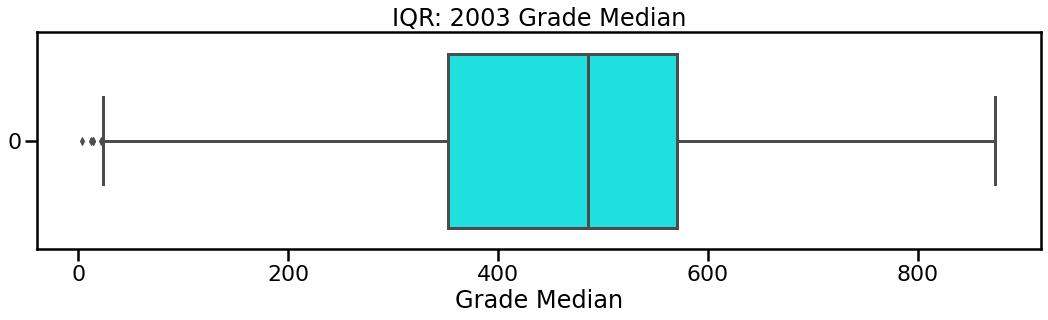

In [97]:
_ = plt.figure(figsize=(18, 4))
_ = sns.boxplot(data=df2003.grade_median, orient='h', color='cyan')
_ = plt.title('IQR: 2003 Grade Median')
_ = plt.xlabel('Grade Median')

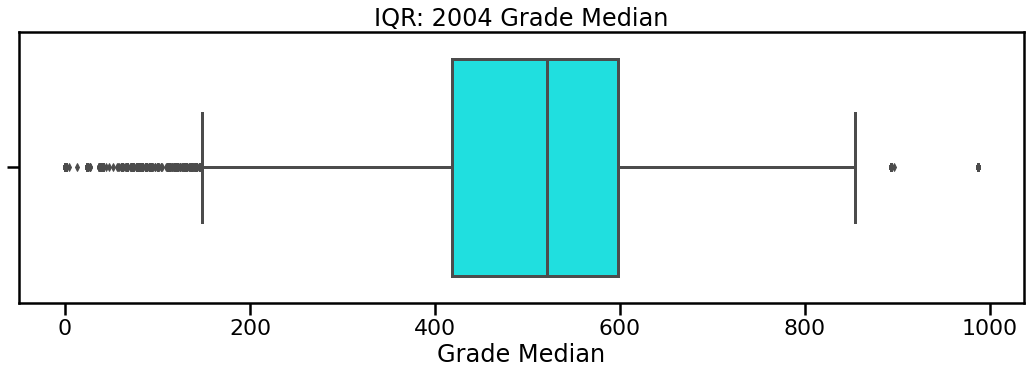

In [98]:
_ = plt.figure(figsize=(18, 5))
_ = sns.boxplot(df2004.grade_median, orient='h', color='cyan')
_ = plt.title('IQR: 2004 Grade Median')
_ = plt.xlabel('Grade Median')

### The 2004 dataset has a more narrow IQR than that of 2003.

## I cram the data into a normal bell curve using boxcox and then add the fitted data into the grades DataFrame. 

### Boxcox and df2003.grade_median

#### Boxcox will not compute numbers less than or equal to 0, so I replace 0s with the next closest number: 1.

In [99]:
df2004.grade_median.replace(to_replace=0, value=1, inplace=True)
df2004.grade_median.where(df2004.grade_median < 0.001).count()

0

In [100]:
fitted_data_03, fitted_lambda_03 = stats.boxcox(df2003.grade_median)

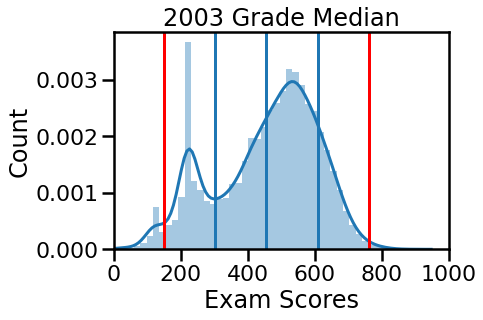

In [101]:
_ = sns.distplot(df2003.grade_median)
_ = plt.axvline(np.mean(df2003.grade_median) + np.std(df2003.grade_median))
_ = plt.axvline(np.mean(df2003.grade_median) + 2 * np.std(df2003.grade_median), c='r')
_ = plt.axvline(np.mean(df2003.grade_median) - np.std(df2003.grade_median))
_ = plt.axvline(np.mean(df2003.grade_median) - 2 * np.std(df2003.grade_median), c='r')
_ = plt.axvline(np.mean(df2003.grade_median))
_ = plt.xlim(0, 1000)
_ = plt.title('2003 Grade Median')
_ = plt.xlabel('Exam Scores')
_ = plt.ylabel('Count')

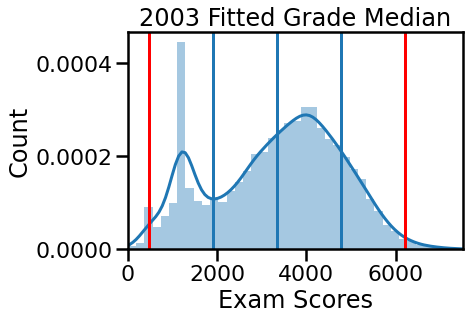

In [102]:
_ = sns.distplot(fitted_data_03)
_ = plt.axvline(np.mean(fitted_data_03) + np.std(fitted_data_03))
_ = plt.axvline(np.mean(fitted_data_03) + 2 * np.std(fitted_data_03), c='r')
_ = plt.axvline(np.mean(fitted_data_03) - np.std(fitted_data_03))
_ = plt.axvline(np.mean(fitted_data_03) - 2 * np.std(fitted_data_03), c='r')
_ = plt.axvline(np.mean(fitted_data_03))
_ = plt.title('2003 Fitted Grade Median')
_ = plt.xlim(0, 7500)
_ = plt.xlabel('Exam Scores')
_ = plt.ylabel('Count')

In [103]:
print(f'03: Excess kurtosis of normal distribution (should be 0): {stats.kurtosis(df2003.grade_median):.3f}\n\
03: Skewness of normal distribution (should be 0): {stats.skew(df2003.grade_median):.3f}')

03: Excess kurtosis of normal distribution (should be 0): -0.629
03: Skewness of normal distribution (should be 0): -0.455


In [104]:
print(f'03, fitted: Excess kurtosis of normal distribution (should be 0): {stats.kurtosis(fitted_data_03):.3f}\n\
03, fitted: Skewness of normal distribution (should be 0): {stats.skew(fitted_data_03):.3f}')

03, fitted: Excess kurtosis of normal distribution (should be 0): -0.779
03, fitted: Skewness of normal distribution (should be 0): -0.209


#### Though the shape of the bell curve is less idea with the fitted data, we have achieved a closer approximation of a normal bell curve.

### Boxcox and df2004.grade_median

#### Boxcox will not compute numbers less than or equal to 0, so I replace 0s with the next closest number: 1.

In [105]:
df2004.grade_median.replace(to_replace=0, value=1, inplace=True)
df2004.grade_median.where(df2004.grade_median < 0.001).count()

0

In [106]:
fitted_data_04, fitted_lambda_04 = stats.boxcox(df2004.grade_median)

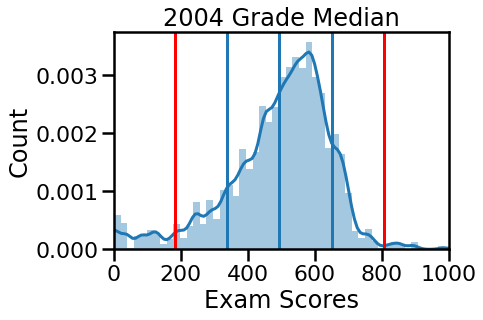

In [107]:
_ = sns.distplot(df2004.grade_median)
_ = plt.axvline(np.mean(df2004.grade_median) + np.std(df2004.grade_median))
_ = plt.axvline(np.mean(df2004.grade_median) + 2 * np.std(df2004.grade_median), c='r')
_ = plt.axvline(np.mean(df2004.grade_median) - np.std(df2004.grade_median))
_ = plt.axvline(np.mean(df2004.grade_median) - 2 * np.std(df2004.grade_median), c='r')
_ = plt.axvline(np.mean(df2004.grade_median))
_ = plt.xlim(0, 1000)
_ = plt.title('2004 Grade Median')
_ = plt.xlabel('Exam Scores')
_ = plt.ylabel('Count')

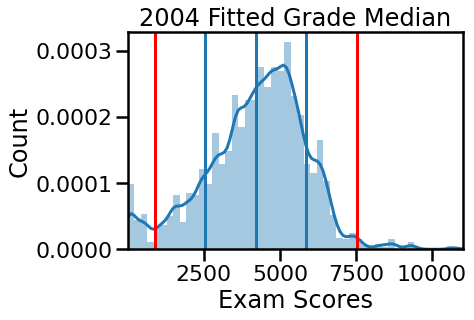

In [108]:
_ = sns.distplot(fitted_data_04)
_ = plt.axvline(np.mean(fitted_data_04) + np.std(fitted_data_04))
_ = plt.axvline(np.mean(fitted_data_04) + 2 * np.std(fitted_data_04), c='r')
_ = plt.axvline(np.mean(fitted_data_04) - np.std(fitted_data_04))
_ = plt.axvline(np.mean(fitted_data_04) - 2 * np.std(fitted_data_04), c='r')
_ = plt.axvline(np.mean(fitted_data_04))
_ = plt.xlim(1, 11000)
_ = plt.title('2004 Fitted Grade Median')
_ = plt.xlabel('Exam Scores')
_ = plt.ylabel('Count')

In [109]:
print(f'04: Excess kurtosis of normal distribution (should be 0): {stats.kurtosis(df2004.grade_median):.3f}\n\
04: Skewness of normal distribution (should be 0): {stats.skew(df2004.grade_median):.3f}')

04: Excess kurtosis of normal distribution (should be 0): 1.152
04: Skewness of normal distribution (should be 0): -0.897


In [110]:
print(f'04, fitted: Excess kurtosis of normal distribution (should be 0): {stats.kurtosis(fitted_data_04):.3f}\n\
04, fitted: Skewness of normal distribution (should be 0): {stats.skew(fitted_data_04):.3f}')

04, fitted: Excess kurtosis of normal distribution (should be 0): 0.353
04, fitted: Skewness of normal distribution (should be 0): -0.351


#### Unlike the 2003 fitted data, these form a better kurtosis and skew all around.

### Add the fitted data in the DataFrames

In [111]:
# Add two columns of the fitted data from boxcox
df2003.insert(1, 'grade_median_fitted', fitted_data_03)
df2004.insert(1, 'grade_median_fitted', fitted_data_04)

### Compare and Contrast Standard Deviations

In [112]:
# make df with grades from both years
grades = pd.merge(df2003[['childcode', 'grade_median_fitted']],
                             df2004[['childcode', 'grade_median_fitted']],
                       on='childcode', how = 'outer', suffixes = ('_03', '_04'))
grades = grades.drop(columns=['childcode'])
print('Standard Deviations:\n', np.std(grades))

Standard Deviations:
 grade_median_fitted_03    1370.084488
grade_median_fitted_04    1659.222987
dtype: float64


## Observe Correlations

### 2003

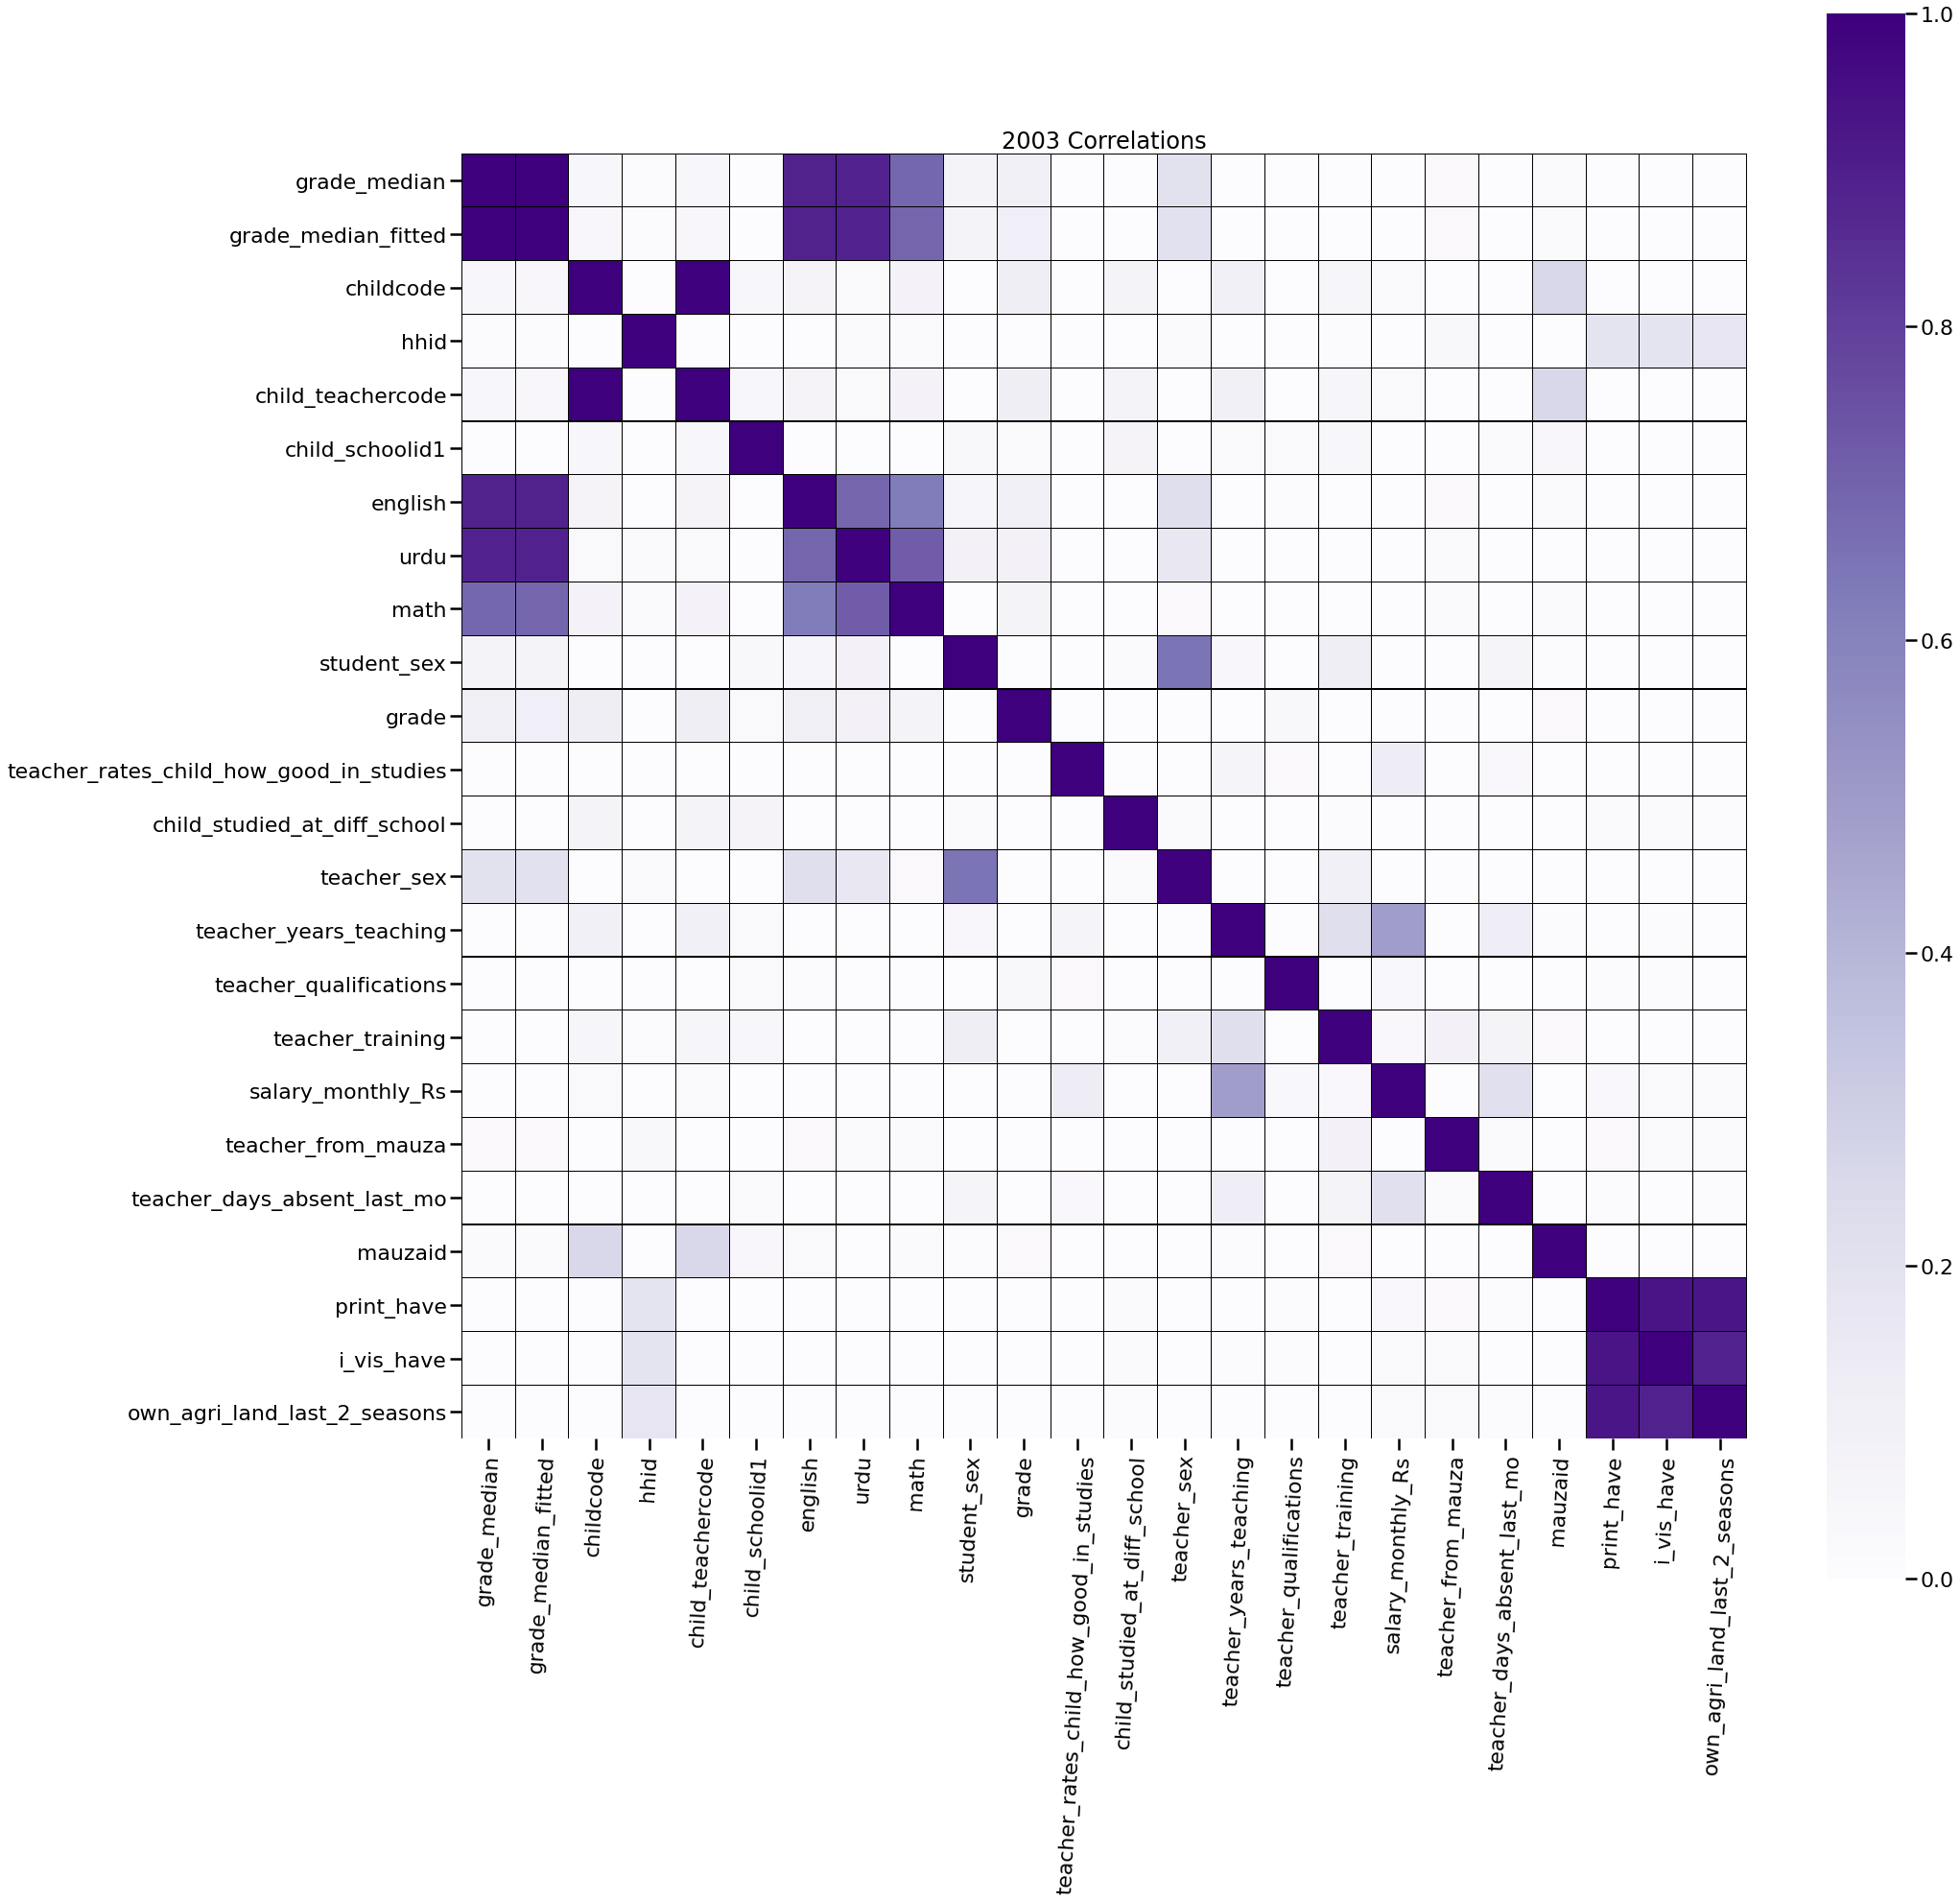

In [113]:
_ = plt.figure(figsize=(30, 30))
_ = sns.heatmap(df2003.corr(),square=True,vmin=0, vmax=1,cmap='Purples',linewidths=0.1,linecolor='k')
_ = plt.title('2003 Correlations')
_ = plt.xticks(rotation=87)

### Only for 2003, there is a correlation between teacher and student sex.

In [114]:
matrix_df2003 = pps.matrix(df2003.copy())[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

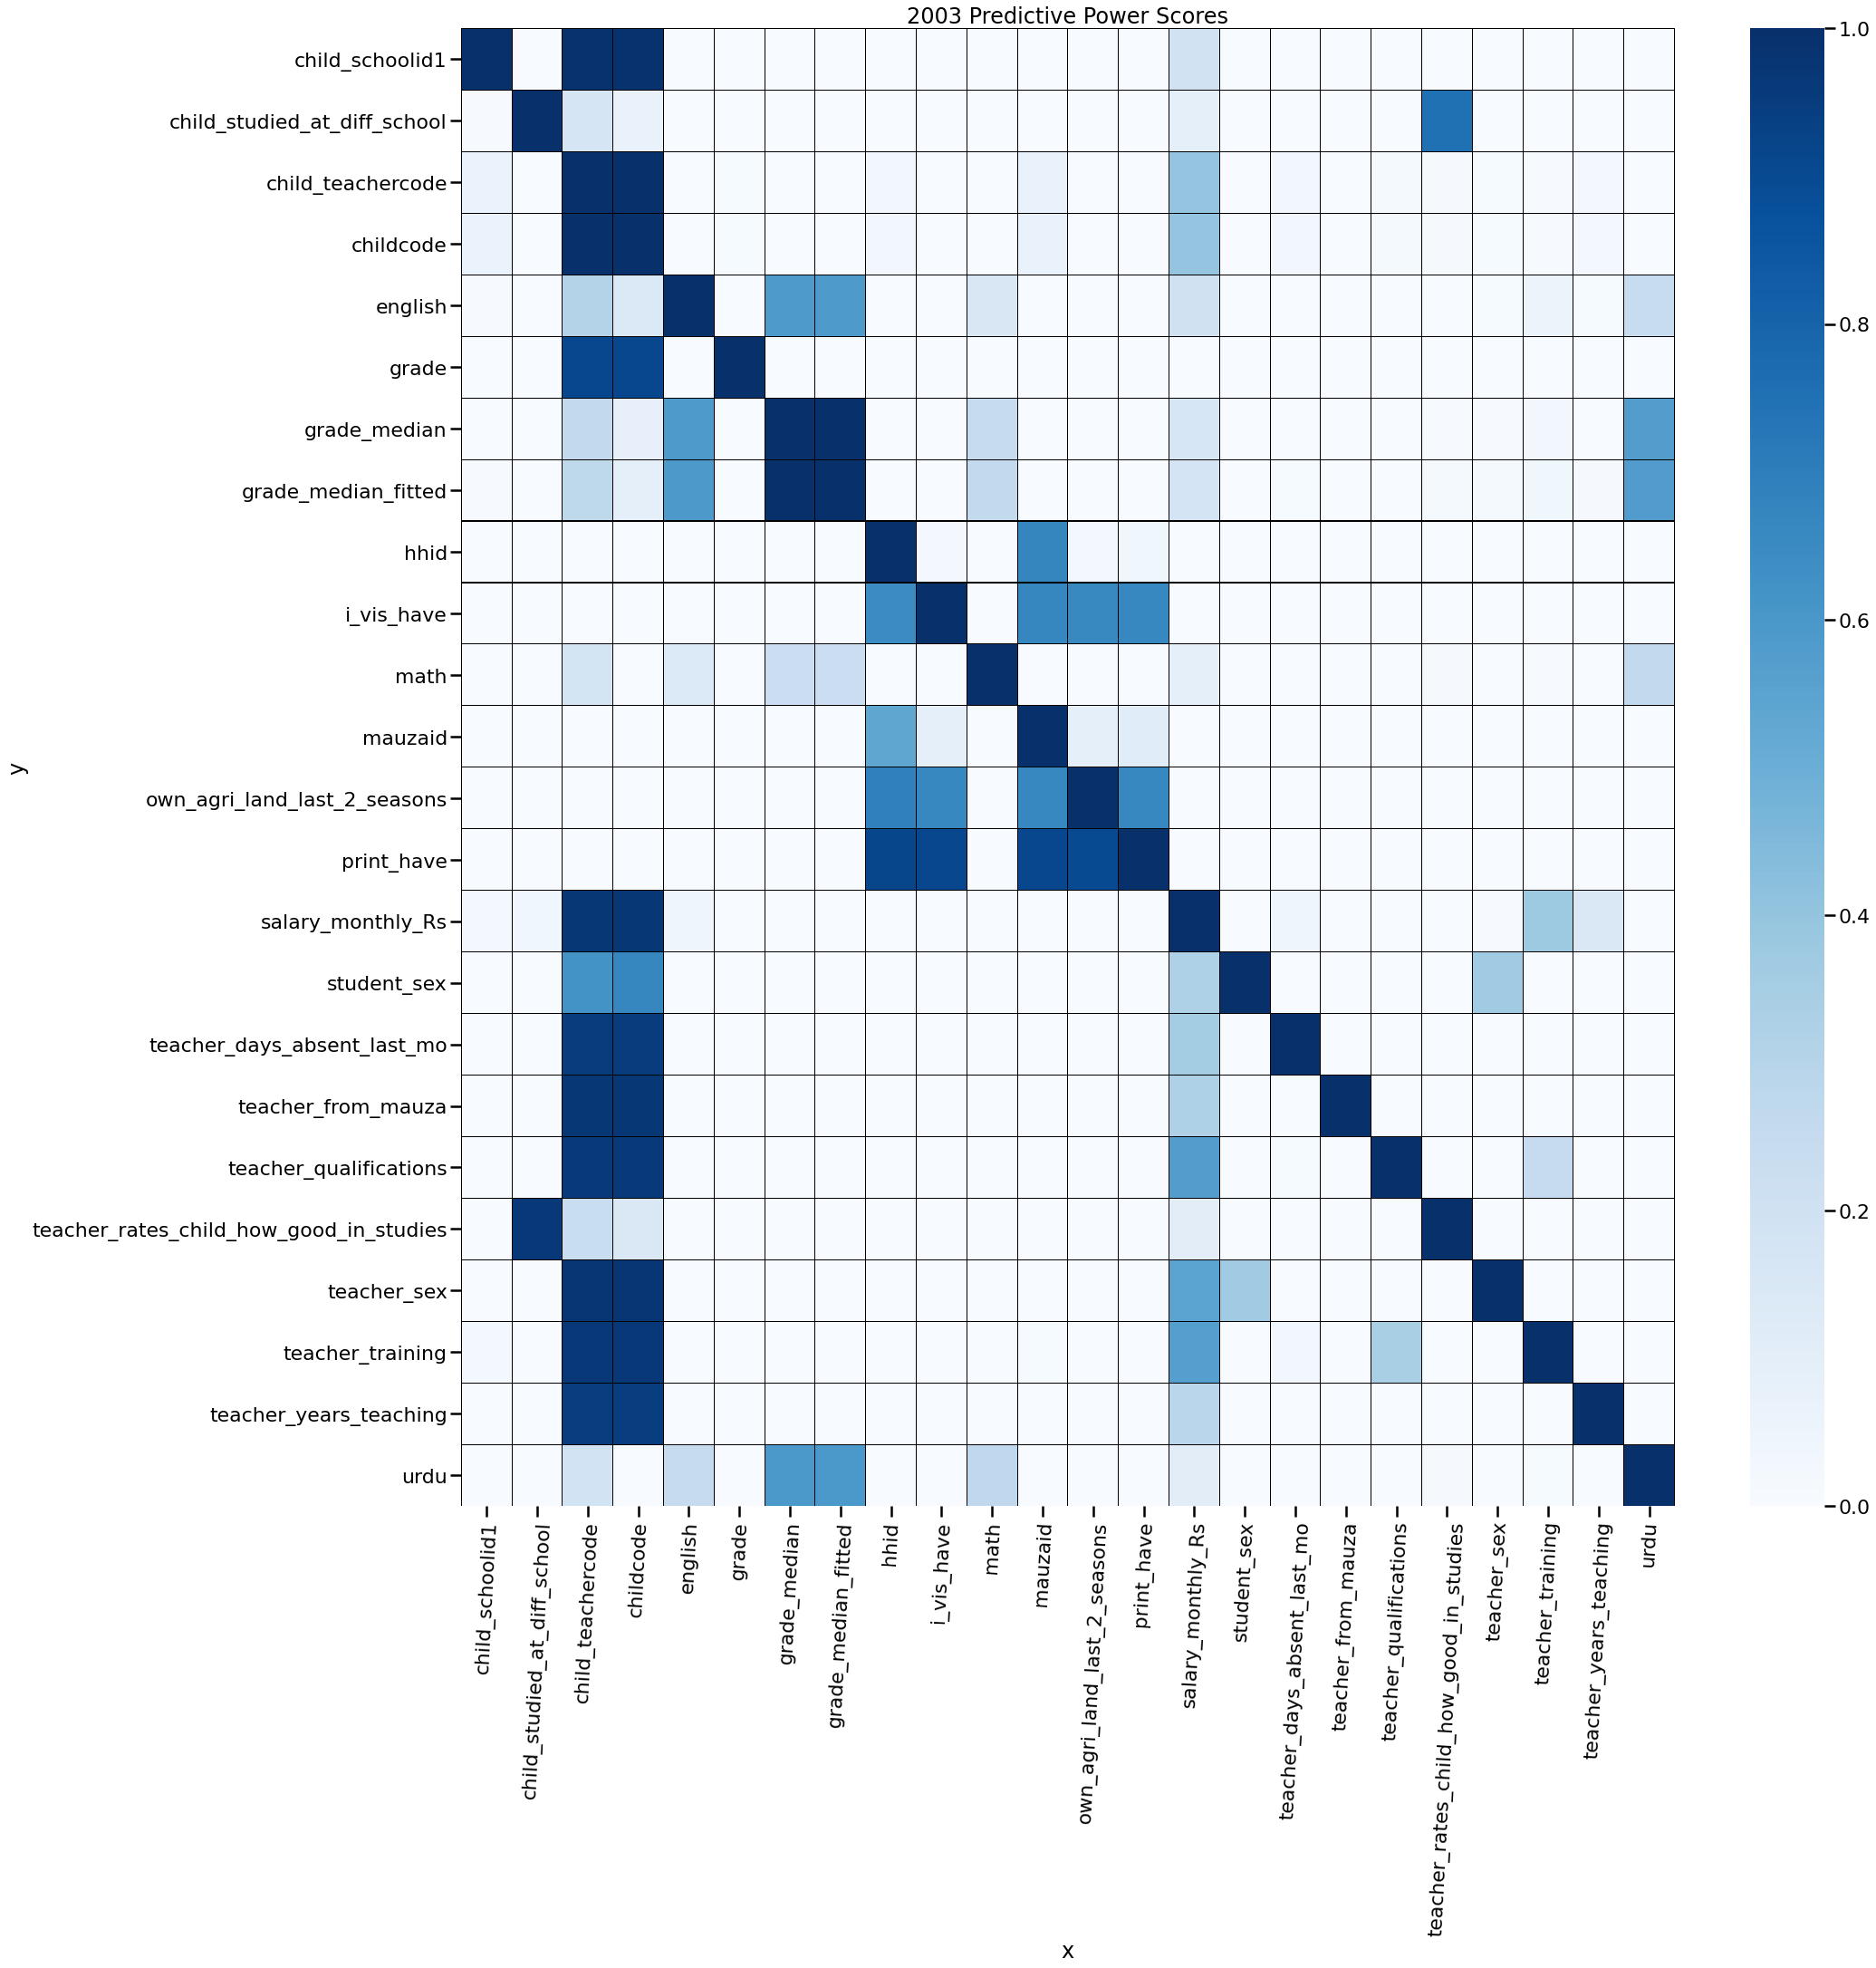

In [115]:
_ = plt.figure(figsize=(30, 30))
_ = sns.heatmap(matrix_df2003, vmin=0, vmax=1, cmap="Blues", linewidths=0.1, linecolor='k')
_ = plt.title('2003 Predictive Power Scores')
_ = plt.xticks(rotation=87)

### 2003 Predictive Power Scores for 'grade_median_fitted'

In [116]:
df2003_pps = pps.matrix(df2003)

In [117]:
df2003_pps.query('x == "grade_median_fitted" & ppscore > 0.01').sort_values(by=['ppscore'],ascending=False)[2:]

x        y   ppscore        case  is_valid_score  \
31  grade_median_fitted     urdu  0.594023  regression            True   
30  grade_median_fitted  english  0.589780  regression            True   
32  grade_median_fitted     math  0.222702  regression            True   

                 metric  baseline_score  model_score                    model  
31  mean absolute error        118.7878    48.225132  DecisionTreeRegressor()  
30  mean absolute error        116.7814    47.906028  DecisionTreeRegressor()  
32  mean absolute error        116.4030    90.479785  DecisionTreeRegressor()

In [118]:
df2003_pps.query('y == "grade_median_fitted" & ppscore > 0.01').sort_values(by=['ppscore'],ascending=False)[2:]

x                    y   ppscore  \
145                                  english  grade_median_fitted  0.590254   
169                                     urdu  grade_median_fitted  0.581644   
97                         child_teachercode  grade_median_fitted  0.274411   
193                                     math  grade_median_fitted  0.257869   
409                        salary_monthly_Rs  grade_median_fitted  0.176480   
49                                 childcode  grade_median_fitted  0.095510   
385                         teacher_training  grade_median_fitted  0.040940   
265  teacher_rates_child_how_good_in_studies  grade_median_fitted  0.016774   
313                              teacher_sex  grade_median_fitted  0.016630   
337                   teacher_years_teaching  grade_median_fitted  0.013918   

           case  is_valid_score               metric  baseline_score  \
145  regression            True  mean absolute error     1179.053007   
169  regression            True  mean absolute error     1179.053007   
97   regression            True  mean absolute error     1179.053007   
193  regression            True  mean absolute error     1179.053007   
409  regression            True  mean absolute error     1179.053007   
49   regression            True  mean absolute error     1179.053007   
385  regression            True  mean absolute error     1179.053007   
265  regression            True  mean absolute error     1179.053007   
313  regression            True  mean absolute error     1179.053007   
337  regression            True  mean absolute error     1179.053007   

     model_score                    model  
145   483.112144  DecisionTreeRegressor()  
169   493.263345  DecisionTreeRegressor()  
97    855.508165  DecisionTreeRegressor()  
193   875.011913  DecisionTreeRegressor()  
409   970.973605  DecisionTreeRegressor()  
49   1066.441120  DecisionTreeRegressor()  
385  1130.783022  DecisionTreeRegressor()  
265  1159.276088  DecisionTreeRegressor()  
313  1159.444881  DecisionTreeRegressor()  
337  1162.642597  DecisionTreeRegressor()

#### Predictive power scores detect non-linear relationships between data that (unlike correlations) are not necessarily symmetric. For example, the city in which someone lives may be discovered if one knows the zip code, but its zip code will not be found if one only knows the city. We see asymmetric relationships when 'grade_median_fitted' is x and y. First, there are more relationships between 'grade_median_fitted' when calculated as y instead of x. Second, the features that has a relationship to 'grade_median_fitted' as both x and y score differently in each case. Math, for example scores .22 as y, but .72 as x. This means that a student's math score predicts his grade median better than vice-versa.

#### Notice that we know there is a strong relationship between a child's childcode and grade median but lack knowledge about the nature of that relationship. We come up against a limitation of the predictive power score: it cannot show the nature of the relationship between a target and variable.

#### Hhid is household ID and was probably determined by in what area a child lived.

### 2004

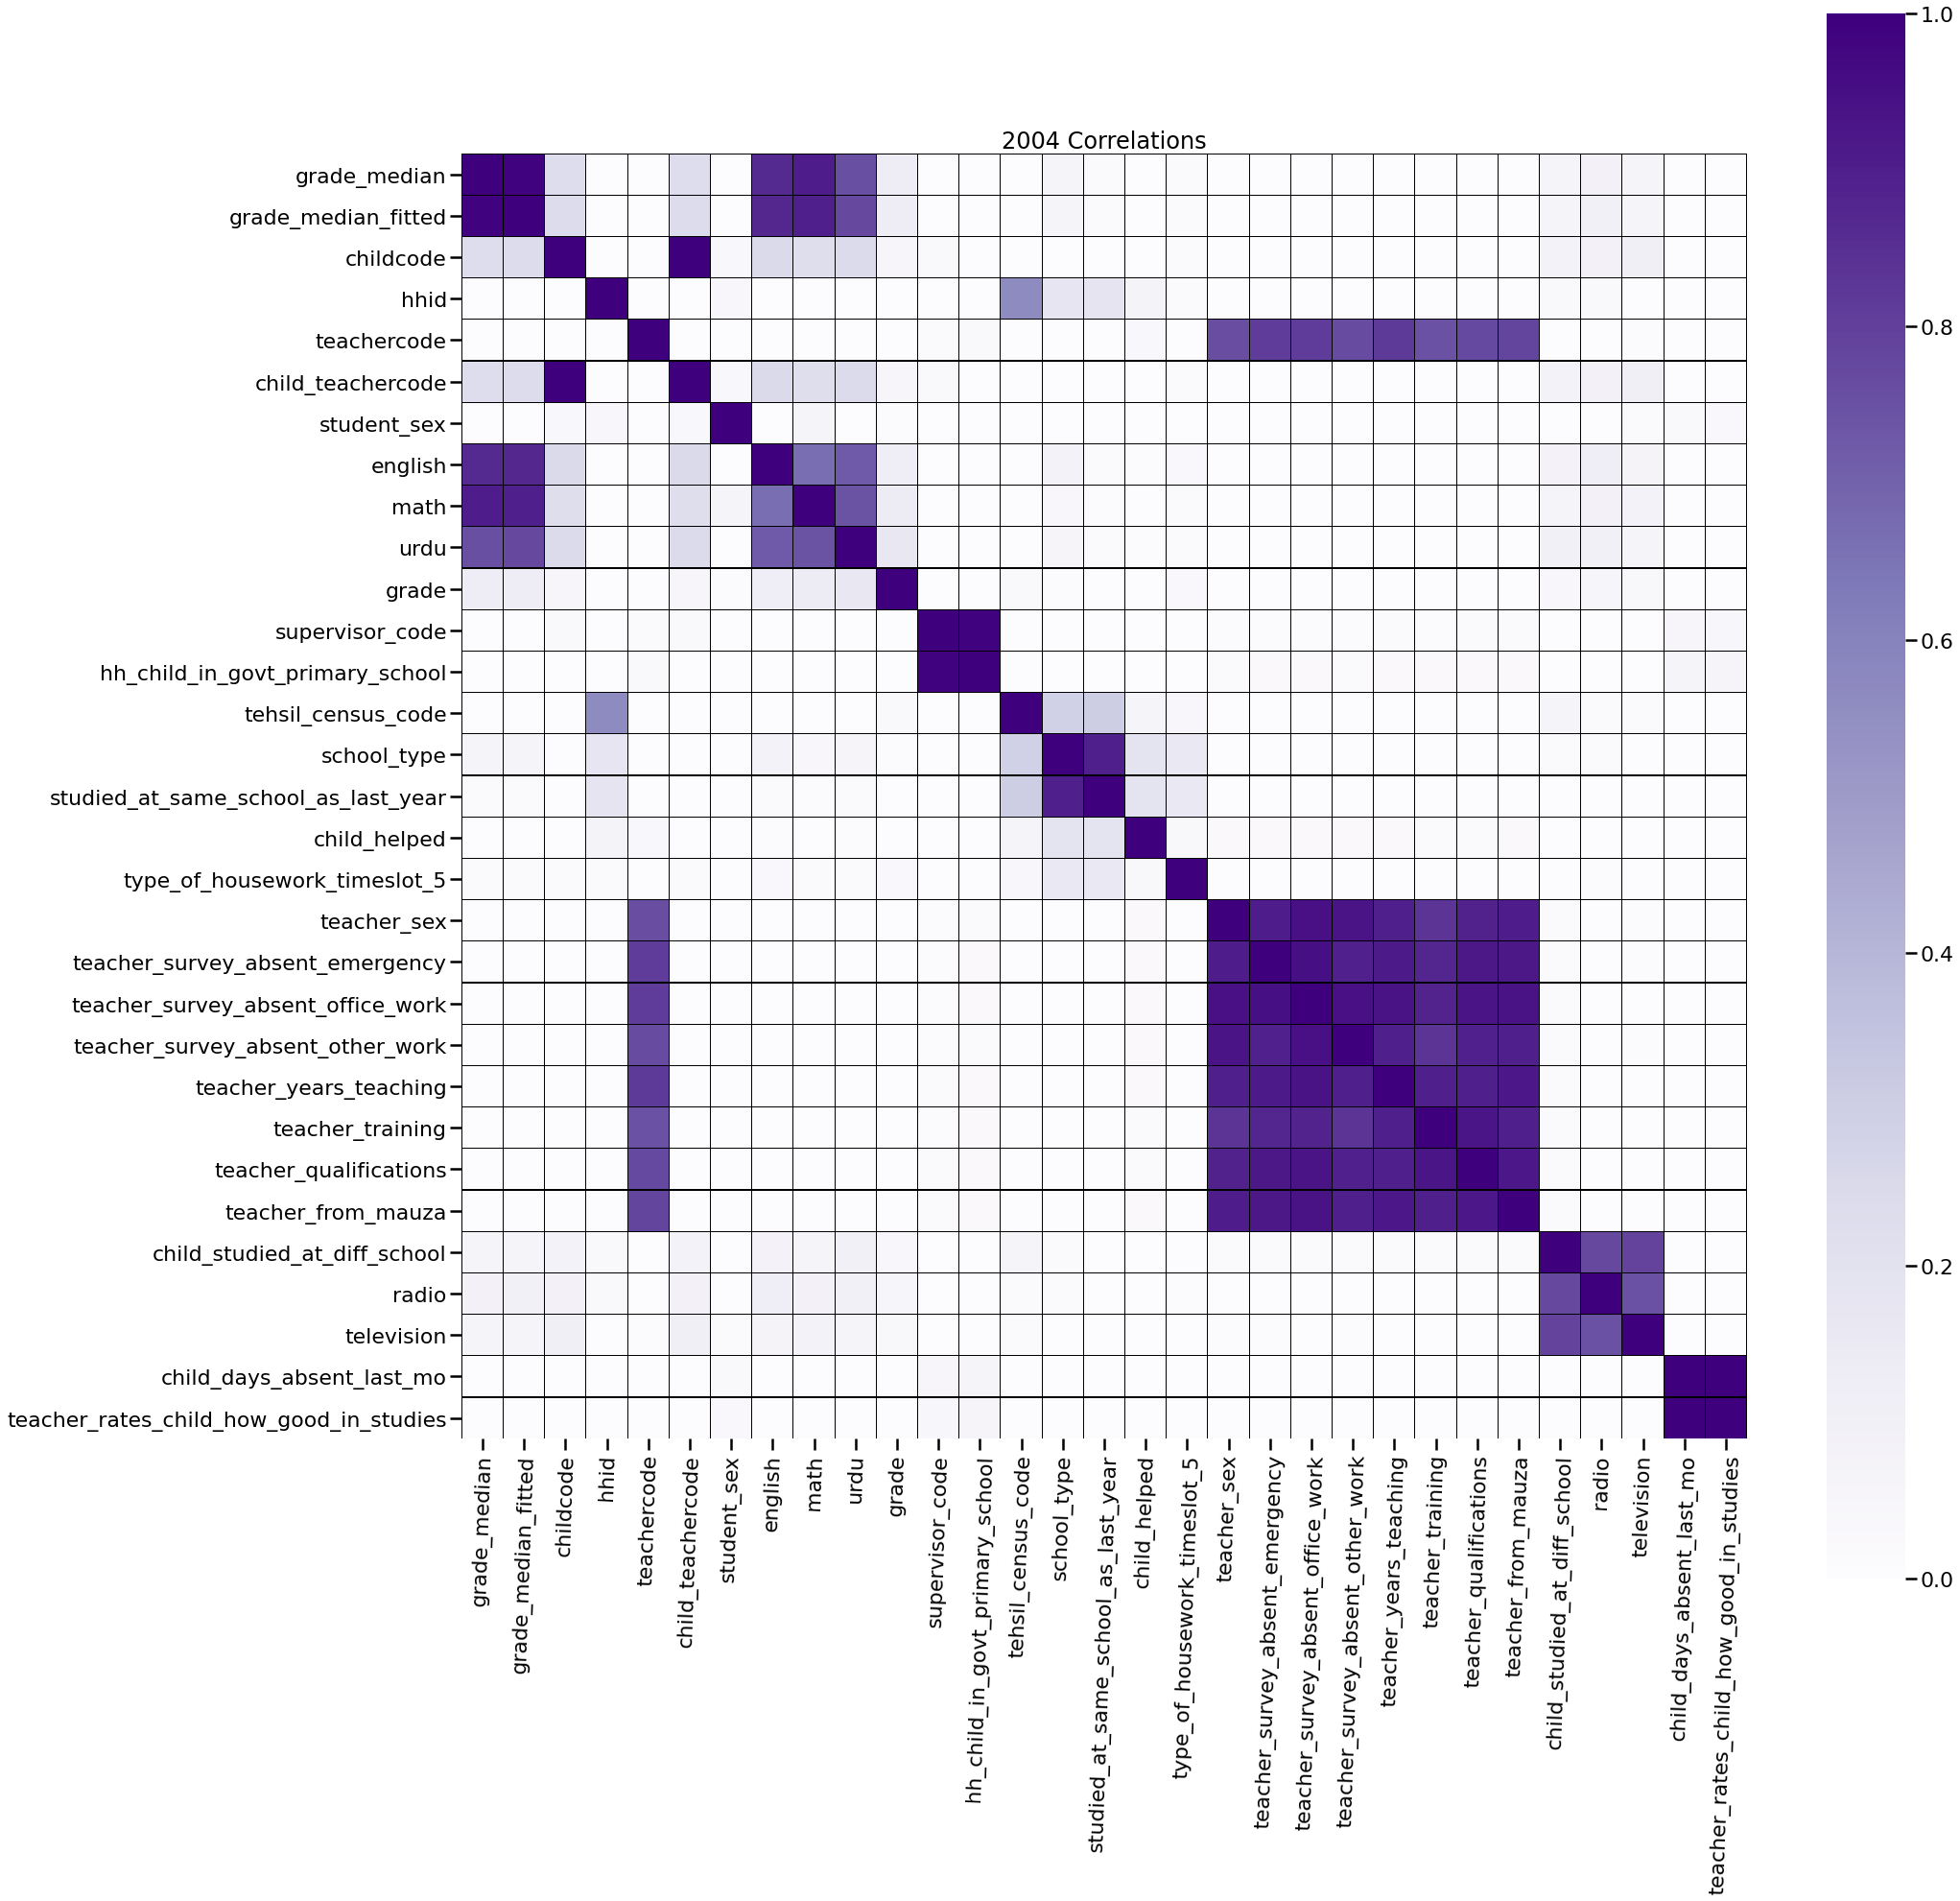

In [119]:
_ = plt.figure(figsize=(30, 30))
_ = sns.heatmap(df2004.corr(), square=True,vmin=0, vmax=1, cmap='Purples', linewidths=0.1, linecolor='k')
_ = plt.title('2004 Correlations')
_ = plt.xticks(rotation=88)

In [120]:
matrix_df2004 = pps.matrix(df2004.copy())[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

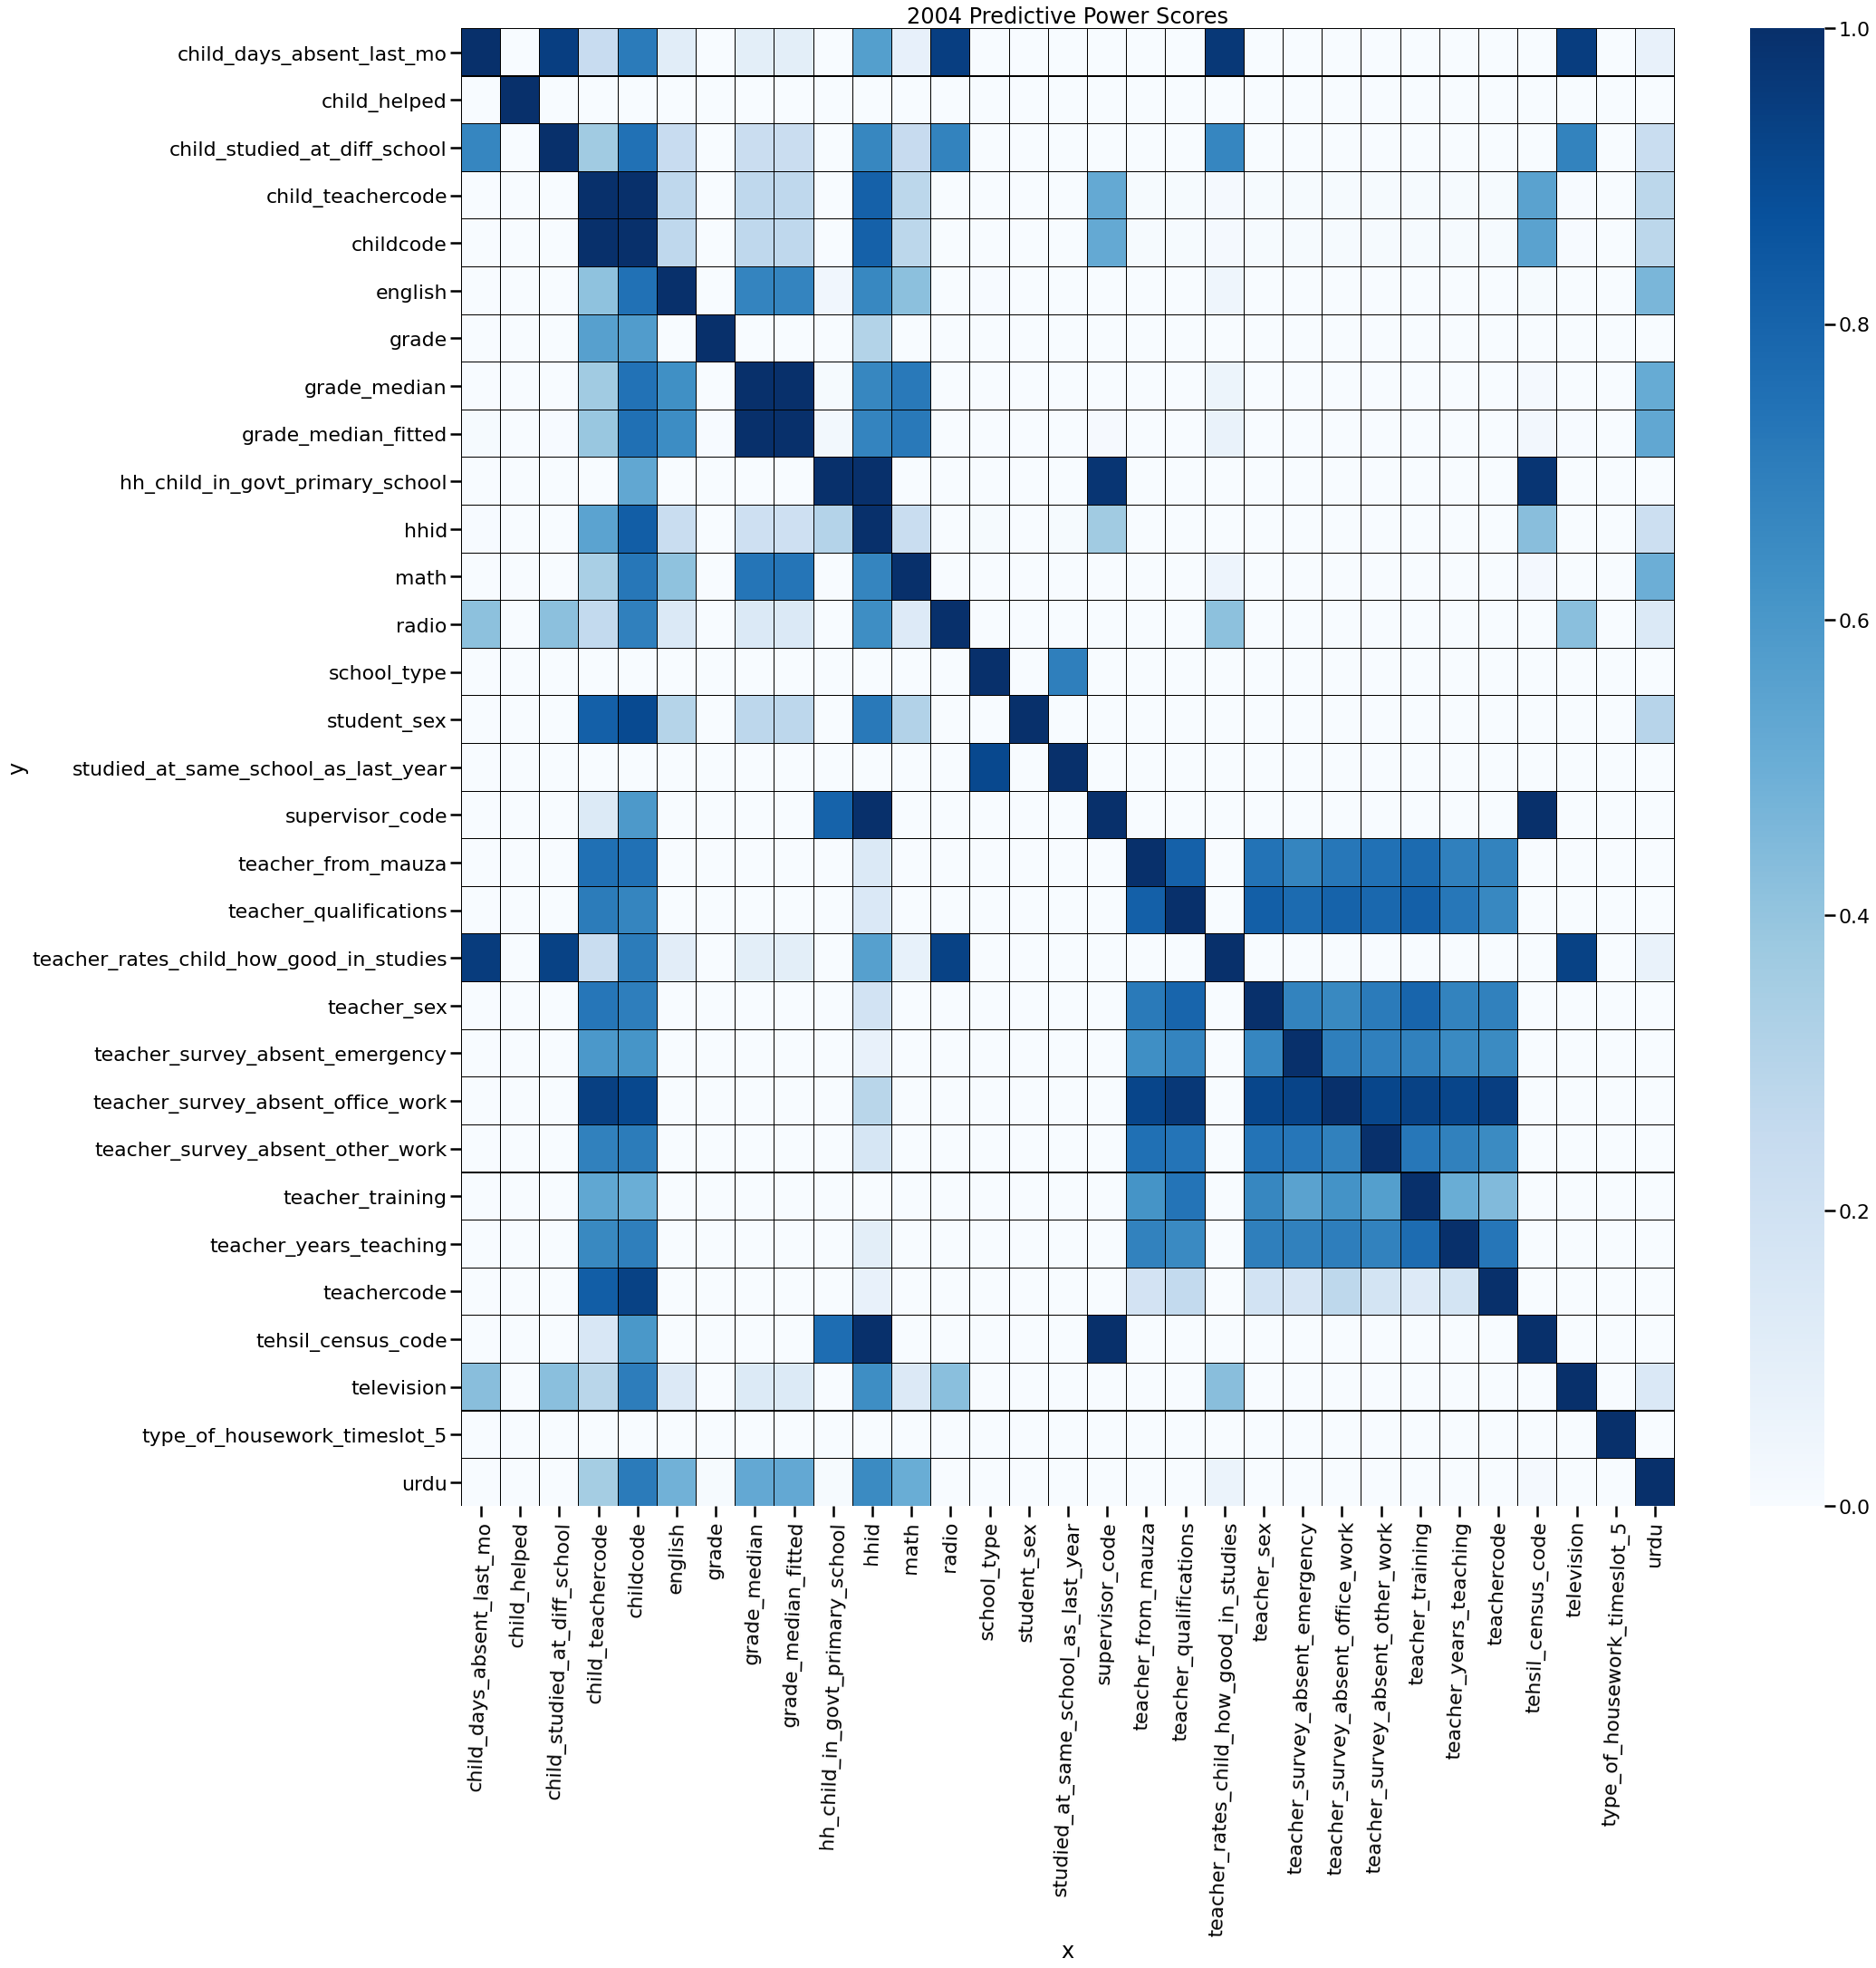

In [121]:
_ = plt.figure(figsize=(30, 30))
_ = sns.heatmap(matrix_df2004, vmin=0, vmax=1, cmap="Blues", linewidths=0.1, linecolor='k')
_ = plt.title('2004 Predictive Power Scores')
_ = plt.xticks(rotation=88)

### 2004 Predictive Power Scores for 'grade_median_fitted'

In [122]:
df2004_pps = pps.matrix(df2004, output='df')

In [123]:
df2004_pps.query('x == "grade_median_fitted" & ppscore > 0.01').sort_values(by=['ppscore'],ascending=False)[2:]

x                                        y   ppscore  \
39  grade_median_fitted                                     math  0.730615   
38  grade_median_fitted                                  english  0.676129   
40  grade_median_fitted                                     urdu  0.526956   
37  grade_median_fitted                              student_sex  0.281115   
36  grade_median_fitted                        child_teachercode  0.271644   
33  grade_median_fitted                                childcode  0.271611   
57  grade_median_fitted             child_studied_at_diff_school  0.233652   
34  grade_median_fitted                                     hhid  0.208376   
58  grade_median_fitted                                    radio  0.141095   
59  grade_median_fitted                               television  0.135485   
60  grade_median_fitted                child_days_absent_last_mo  0.102187   
61  grade_median_fitted  teacher_rates_child_how_good_in_studies  0.101564   

          case  is_valid_score               metric  baseline_score  \
39  regression            True  mean absolute error    1.190044e+02   
38  regression            True  mean absolute error    1.018206e+02   
40  regression            True  mean absolute error    1.102496e+02   
37  regression            True  mean absolute error    4.562000e-01   
36  regression            True  mean absolute error    4.003572e+05   
33  regression            True  mean absolute error    4.003227e+06   
57  regression            True  mean absolute error    7.620000e-01   
34  regression            True  mean absolute error    3.119149e+04   
58  regression            True  mean absolute error    5.604000e-01   
59  regression            True  mean absolute error    5.600000e-01   
60  regression            True  mean absolute error    3.023080e+01   
61  regression            True  mean absolute error    2.894360e+01   

     model_score                    model  
39  3.205803e+01  DecisionTreeRegressor()  
38  3.297673e+01  DecisionTreeRegressor()  
40  5.215290e+01  DecisionTreeRegressor()  
37  3.279555e-01  DecisionTreeRegressor()  
36  2.916026e+05  DecisionTreeRegressor()  
33  2.915905e+06  DecisionTreeRegressor()  
57  5.839575e-01  DecisionTreeRegressor()  
34  2.469193e+04  DecisionTreeRegressor()  
58  4.813306e-01  DecisionTreeRegressor()  
59  4.841284e-01  DecisionTreeRegressor()  
60  2.714160e+01  DecisionTreeRegressor()  
61  2.600397e+01  DecisionTreeRegressor()

In [124]:
df2004_pps.query('y == "grade_median_fitted" & ppscore > 0.01').sort_values(by=['ppscore'],ascending=False)[2:]

x                    y   ppscore  \
63                                 childcode  grade_median_fitted  0.750722   
249                                     math  grade_median_fitted  0.721916   
94                                      hhid  grade_median_fitted  0.675942   
218                                  english  grade_median_fitted  0.641680   
280                                     urdu  grade_median_fitted  0.528018   
156                        child_teachercode  grade_median_fitted  0.389172   
931  teacher_rates_child_how_good_in_studies  grade_median_fitted  0.070731   
404                       tehsil_census_code  grade_median_fitted  0.030817   
373          hh_child_in_govt_primary_school  grade_median_fitted  0.024000   
342                          supervisor_code  grade_median_fitted  0.014571   

           case  is_valid_score               metric  baseline_score  \
63   regression            True  mean absolute error     1303.192591   
249  regression            True  mean absolute error     1303.192591   
94   regression            True  mean absolute error     1303.192591   
218  regression            True  mean absolute error     1303.192591   
280  regression            True  mean absolute error     1303.192591   
156  regression            True  mean absolute error     1303.192591   
931  regression            True  mean absolute error     1303.192591   
404  regression            True  mean absolute error     1303.192591   
373  regression            True  mean absolute error     1303.192591   
342  regression            True  mean absolute error     1303.192591   

     model_score                    model  
63    324.856831  DecisionTreeRegressor()  
249   362.397096  DecisionTreeRegressor()  
94    422.309385  DecisionTreeRegressor()  
218   466.960590  DecisionTreeRegressor()  
280   615.083915  DecisionTreeRegressor()  
156   796.025950  DecisionTreeRegressor()  
931  1211.016353  DecisionTreeRegressor()  
404  1263.032542  DecisionTreeRegressor()  
373  1271.915749  DecisionTreeRegressor()  
342  1284.203173  DecisionTreeRegressor()

### 2003 OLS

In [125]:
m = ols('math ~ grade_median_fitted', df2003).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                   math   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:33:49   Log-Likelihood:                -73877.
No. Observations:               12110   AIC:                         1.478e+05
Df Residuals:                   12108   BIC:                         1.478e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             258.5703    

In [126]:
m = ols('urdu ~ grade_median_fitted', df2003).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                   urdu   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                 4.606e+04
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:33:49   Log-Likelihood:                -68355.
No. Observations:               12110   AIC:                         1.367e+05
Df Residuals:                   12108   BIC:                         1.367e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             189.0978    

In [127]:
m = ols('english ~ grade_median_fitted', df2003).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                english   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                 4.714e+04
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:33:49   Log-Likelihood:                -68238.
No. Observations:               12110   AIC:                         1.365e+05
Df Residuals:                   12108   BIC:                         1.365e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             188.4503    

In [128]:
m = ols('own_agri_land_last_2_seasons ~ grade_median_fitted', df2003).fit()
print(m.summary())

                                 OLS Regression Results                                 
Dep. Variable:     own_agri_land_last_2_seasons   R-squared:                       0.000
Model:                                      OLS   Adj. R-squared:                  0.000
Method:                           Least Squares   F-statistic:                     2.809
Date:                          Sat, 31 Oct 2020   Prob (F-statistic):             0.0938
Time:                                  16:33:49   Log-Likelihood:                -6594.9
No. Observations:                         12110   AIC:                         1.319e+04
Df Residuals:                             12108   BIC:                         1.321e+04
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [129]:
m = ols('salary_monthly_Rs ~ grade_median_fitted', df2003).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:      salary_monthly_Rs   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     1604.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:33:49   Log-Likelihood:            -1.1004e+05
No. Observations:               12110   AIC:                         2.201e+05
Df Residuals:                   12108   BIC:                         2.201e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5957.4594    

### 2004 OLS

In [130]:
m = ols('math ~ grade_median_fitted', df2004).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                   math   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                 2.719e+05
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:33:49   Log-Likelihood:            -3.6198e+05
No. Observations:               64218   AIC:                         7.240e+05
Df Residuals:                   64216   BIC:                         7.240e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             181.3261    

In [131]:
m = ols('urdu ~ grade_median_fitted', df2004).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                   urdu   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                 9.325e+04
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:33:49   Log-Likelihood:            -3.8290e+05
No. Observations:               64218   AIC:                         7.658e+05
Df Residuals:                   64216   BIC:                         7.658e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             264.4343    

In [132]:
m = ols('english ~ grade_median_fitted', df2004).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                english   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                 2.050e+05
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:33:49   Log-Likelihood:            -3.6236e+05
No. Observations:               64218   AIC:                         7.247e+05
Df Residuals:                   64216   BIC:                         7.247e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             234.1159    

In [133]:
m = ols('school_type ~ grade_median_fitted', df2004).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:            school_type   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     271.2
Date:                Sat, 31 Oct 2020   Prob (F-statistic):           8.32e-61
Time:                        16:33:49   Log-Likelihood:                -60609.
No. Observations:               64218   AIC:                         1.212e+05
Df Residuals:                   64216   BIC:                         1.212e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.7244    

In [134]:
m = ols('child_studied_at_diff_school ~ grade_median_fitted', df2004).fit()
print(m.summary())

                                 OLS Regression Results                                 
Dep. Variable:     child_studied_at_diff_school   R-squared:                       0.004
Model:                                      OLS   Adj. R-squared:                  0.004
Method:                           Least Squares   F-statistic:                     288.4
Date:                          Sat, 31 Oct 2020   Prob (F-statistic):           1.55e-64
Time:                                  16:33:50   Log-Likelihood:                -83398.
No. Observations:                         64218   AIC:                         1.668e+05
Df Residuals:                             64216   BIC:                         1.668e+05
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [135]:
m = ols('studied_at_same_school_as_last_year ~ grade_median', df2004).fit()
print(m.summary())

                                     OLS Regression Results                                    
Dep. Variable:     studied_at_same_school_as_last_year   R-squared:                       0.000
Model:                                             OLS   Adj. R-squared:                  0.000
Method:                                  Least Squares   F-statistic:                     23.70
Date:                                 Sat, 31 Oct 2020   Prob (F-statistic):           1.13e-06
Time:                                         16:33:50   Log-Likelihood:                -46171.
No. Observations:                                64218   AIC:                         9.235e+04
Df Residuals:                                    64216   BIC:                         9.236e+04
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
                   coef    std err      

### The last two OLS summaries compare whether a student has ever changed schools versus whether a student changed school just last year.

# Save datasets for next file.

In [138]:
# df2003.to_pickle('.../LEAPS/LEAPS_03_clean2.pkl')
# df2004.to_pickle('.../LEAPS/LEAPS_04_clean2.pkl')